# Configurações

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf 
import random 
import os
from tensorflow.keras.losses import MeanAbsoluteError
from matplotlib.ticker import ScalarFormatter
import pandas as pd

In [3]:
data_folder = '/kaggle/input/binned-dataset-v3/' # path to the folder containing the data
auxiliary_folder = '/kaggle/input/ariel-data-challenge-2024/' # path to the folder containing the train targets and wavelengths informations

## Import dos dados observacionais

In [4]:
# Dados de treino 
data_train = np.load(f'{data_folder}/data_train.npy')
data_train_FGS = np.load(f'{data_folder}/data_train_FGS.npy')

In [5]:
output_dir = './output'

SEED = 42

do_the_mcdropout_wc = True
do_the_mcdropout = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

Directory ./output created.


# Redes 1D para profundidade média de trânsito 

## Pré processamento para modelos 1D

Extraindo o valor médio de transito de cada um dos 673 planetas a partir de do dataset de rótulos 'train_labels', tirando a média de todos os 282 (pois o sinal FGS é descartado) valores de comprimentos de onda (wl)

obs: 'train_labels' são os ground truth spectra, que refere-se ao **espectro verdadeiro** ou **espectro de referência**.

In [6]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)

targets = train_solution[:,1:] # Ignora a coluna 'planet_id'
targets_mean = targets[:,1:].mean(axis = 1) # Utilizado pelas redes 1D para extração do valor médio. Apenas os comprimentos de onda AIRS, pois o ponto FGS (wl_1) não é usado na light curve

N = targets.shape[0]

print('Targets: ',targets.shape) 
print('Targets mean: ',targets_mean.shape)

Targets:  (673, 283)
Targets mean:  (673,)


673 IDs de exoplanetas, 283 wl, sendo 282 do AIRS e o 1º do FGS. Note que no calculo de 'targets_mean' foi desconsiderada a primeira coluna (wl_1) referente a contribuição do instrumento FGS.

In [7]:
signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned  = data_train, data_train_FGS
FGS_column = signal_FGS_diff_transposed_binned.sum(axis = 2) # soma ao longo do eixo X
dataset = np.concatenate([signal_AIRS_diff_transposed_binned, FGS_column[:,:, np.newaxis,:]], axis = 2)

print('signal_AIRS_diff_transposed_binned: ',signal_AIRS_diff_transposed_binned.shape)
print('signal_FGS_diff_transposed_binned: ',signal_FGS_diff_transposed_binned.shape)
print('FGS_column: ',FGS_column.shape)

signal_AIRS_diff_transposed_binned:  (673, 187, 282, 32)
signal_FGS_diff_transposed_binned:  (673, 187, 32, 32)
FGS_column:  (673, 187, 32)


PLOTAR POSTERIORMENTE AS IMAGENS FGS E AIRS (ADC24 Intro training) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

'signal_FGS_diff_transposed_binned' é um array multidimensional de 4 dimensões: (673 IDs de planetas, 187 passos de tempo pra cada ID, 32 pixels na vertical, 32 pixels na horizontal). O processamento feito no bloco de código acima foi somar os fluxos ao longo do eixo 2 (pixels verticais) para os dados do instrumento FGS.

A última linha que opera a concatenação de 'signal_AIRS_diff_transposed_binned' e 'FGS_column' inclui, para cada um dos 187 passos de tempo os 32 valores de fluxo de 'FGS_column' referentes ao mesmo passo de tempo para a dimensão 3 de 'signal_AIRS_diff_transposed_binned' (axis=2, que contem os fluxos de cada um dos 282 wl). Ou seja, essa operação concatena as contribuições de fluxo médio do instrumento FGS aos fluxos do instrumento AIRS para cada passo de tempo respectivo.

Abaixo somamos os 32 pixels no eixo y de cada frame (dimensão 4, que representa o fluxo total para um passo de tempo específico no cubo de imagens ou frames) para transformar os dados em imagens 2D. Ou seja, agora teremos para cada um dos 187 passos de tempo o fluxo total para cada um dos 283 wl específicos.

In [8]:
dataset = dataset.sum(axis=3)

# Após somar ao longo do axis=3 (32 pixels no eixo Y)
print('dataset shape: ',dataset.shape) 

dataset shape:  (673, 187, 283)


In [9]:
# Normalização
def create_dataset_norm(dataset1, dataset2) :
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2

# Normalização pelo espectro da estrela
def norm_star_spectrum (signal) : 
    img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
    return signal/img_star[:,np.newaxis,:]

dataset_norm = norm_star_spectrum(dataset)
dataset_norm = np.transpose(dataset_norm,(0,2,1)) 

## Dividindo targets e observações em treino e validação

In [10]:
cut_inf, cut_sup = 39, 321 # we have previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data file
l = cut_sup - cut_inf + 1 
wls = np.arange(l)

def split (data, N) : 
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets : 
        list_index_1[planet] = True
    data_1 = data[list_index_1] # train list
    data_2 = data[~list_index_1] # validation list
    return data_1, data_2, list_index_1

N_train = 8*N//10

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train) # obs
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train] # targets

print('\ntrain_obs shape: ',train_obs.shape)
print('valid_obs shape: ',valid_obs.shape)
print('\ntrain_targets shape: ',train_targets.shape)
print('valid_targets shape: ',valid_targets.shape)


train_obs shape:  (538, 283, 187)
valid_obs shape:  (135, 283, 187)

train_targets shape:  (538, 283)
valid_targets shape:  (135, 283)


In [11]:
# Calcula o fluxo total para cada um dos 282 wl (somando os 32 pixels ao longo do axis=3)
# para cada um dos 187 passos de tempo
signal_AIRS_diff_transposed_binned = signal_AIRS_diff_transposed_binned.sum(axis=3) # treino

# Calcula a média dos 282 fluxos pra cada um dos 187 passos de tempo (axis=1) e em seguinda a
# média desses mesmos fluxos pra cada 637 IDs de exoplanetas (axis=1 dnv). 'wc_mean' se torna 
# um array de dim=1 que armazena em cada posição o fluxo médio considerando todos 282 wl e
# todos os 187 passos de tempo
wc_mean = signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1) # fluxo médio de cada exoplaneta do conjunto de treino

# Divide cada um dos fluxos somados de todos os 282 wl para cada um dos 187 passos de tempo 
# pelas médias de fluxo para cada ID de exoplaneta. Ou seja, 'white_curve' terá um 
# shape(673, 187) onde cada um dos 187 passos de tempo armazenará os fluxos totais somados divididos
# pela média do fluxo da respectiva observação inteira (para todos 187 passos de tempo)
light_curve = signal_AIRS_diff_transposed_binned.sum(axis=2)/ wc_mean[:, np.newaxis]

print('Light curve shape: ',light_curve.shape)

Light curve shape:  (673, 187)


A **curva de luz (white curve ou light curve)** consiste no somatório do fluxo total de um passo de tempo específico da observação dividido pelo fluxo total médio da observação inteira (ou seja, a média de todos os 187 passos de tempo):

> 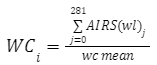

Com *i* representandoREPRESENTANDO O INDICE DO PLANET_ID
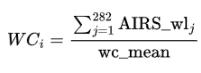

In [12]:
def normalize_wlc(train, valid):
    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)
    
    return train_norm, valid_norm

def normalize (train, valid) : 
    max_train = train.max()  
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)
    
    return train_norm, valid_norm, min_train, max_train

# Split the light curves and targets. OBS: ADICIONAR _NORM DEPOIS EM TRAIN_WC E VALID_WC
train_wc, valid_wc = light_curve[list_index_train], light_curve[~list_index_train]
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]

# Normalize the wlc
train_wc, valid_wc = normalize_wlc(train_wc, valid_wc) 

# Normalize the targets 
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc, valid_targets_wc)

#print("wc_mean_norm: ", wc_mean_norm.shape)
print("\ntrain_wc shape: ", train_wc.shape)
print("valid_wc shape: ", valid_wc.shape)
print("\ntrain_targets_wc shape: ", train_targets_wc.shape)
print("valid_targets_wc shape: ", valid_targets_wc.shape)
print("\ntrain_targets_wc_norm shape: ", train_targets_wc_norm.shape)
print("valid_targets_wc_norm shape: ", valid_targets_wc_norm.shape)


train_wc shape:  (538, 187)
valid_wc shape:  (135, 187)

train_targets_wc shape:  (538,)
valid_targets_wc shape:  (135,)

train_targets_wc_norm shape:  (538,)
valid_targets_wc_norm shape:  (135,)


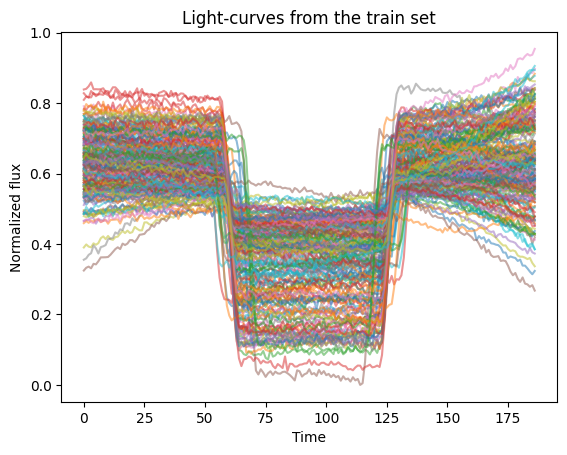

In [13]:
plt.figure()
for i in range (200): 
    plt.plot(train_wc[-i], '-', alpha = 0.5)
plt.title('Light-curves from the train set') 
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()

## Modelo 1D CNN

### Imports

In [14]:
pip install scikeras 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 66.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible

In [15]:
# Redes neurais
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, AveragePooling1D, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
import itertools
import time

_________________________________________________________________________________________________________________________________________

### Estrutura da rede 1D CNN

In [31]:
input_wc = Input((187,1))
x = Conv1D(32, 3, activation='relu')(input_wc)
x = MaxPooling1D()(x)
x = BatchNormalization() (x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
x = Dense(100, activation='relu')(x)
x = Dropout(0.1)(x, training = True)
output_wc = Dense(1, activation='linear')(x)

model_wc_1dcnn = Model(inputs=input_wc, outputs=output_wc)
model_wc_1dcnn.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 92, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 90, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 19, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │     1,152,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,429 (5.08 MB)

 Trainable params: 1,332,365 (5.08 MB)

 Non-trainable params: 64 (256.00 B)

### Treinando o modelo 1D CNN

In [32]:
optimizer = SGD(0.001)
model_wc_1dcnn.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])

checkpoint_filepath_1dcnn = 'output/model_1dcnn.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath_1dcnn,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

start_time = time.time()

# Fixando seed para reprodutibilidade dos processos aleatórios
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

print('Running ...')
history = model_wc_1dcnn.fit(
    x = train_wc,  
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),  
    batch_size=16,
    epochs= 1200,
    shuffle=True,
    verbose=0, 
    callbacks=[model_ckt]
    )
print('Done.')

end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo de treinamento: 12 minutos e 55 segundos.


### Avaliação dos resultados 1D CNN

#### Curvas de erro 1D CNN

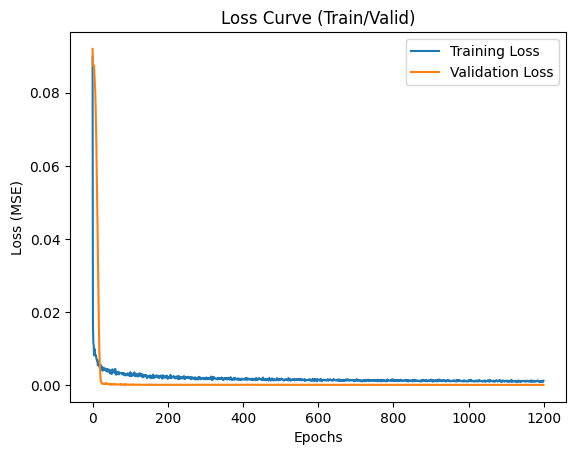

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve (Train/Valid)') 
plt.xlabel('Epochs') 
plt.ylabel('Loss (MSE)') 
plt.show()

#### Dropout 1D CNN

O **MC Dropout** (Monte Carlo Dropout) é uma técnica para obter previsões de um modelo de rede neural com incerteza, utilizando o dropout durante o treinamento e a inferência.

In [34]:
model_wc_1dcnn = load_model(checkpoint_filepath_1dcnn)

nb_dropout_wc = 1000
do_the_mcdropout_wc_1dcnn = True  # Ativa o MC Dropout explicitamente

def unstandardizing (data, min_train_valid, max_train_valid) : 
    return data * (max_train_valid - min_train_valid) + min_train_valid

def MC_dropout_WC (model, data, nb_dropout) : 
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout) : 
        predictions[i,:] = model.predict(data, verbose = 0).flatten()
    return predictions

start_time = time.time()

if do_the_mcdropout_wc_1dcnn :
    print('Running ...')
    prediction_valid_wc_1dcnn = MC_dropout_WC(model_wc_1dcnn, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all_1dcnn = unstandardizing(prediction_valid_wc_1dcnn, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc_1dcnn, spectre_valid_std_wc_1dcnn = spectre_valid_wc_all_1dcnn.mean(axis = 0), spectre_valid_wc_all_1dcnn.std(axis = 0)
    print('Done.')

else : 
    spectre_valid_wc_1dcnn = model_wc_1dcnn.predict(valid_wc).flatten()
    spectre_valid_wc_1dcnn = unstandardizing(spectre_valid_wc_1dcnn, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc_1dcnn = 0.1*np.abs(spectre_valid_wc_1dcnn)
    
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo de treinamento: 1 minutos e 54 segundos.


#### Plot das predições e resíduos 1D CNN

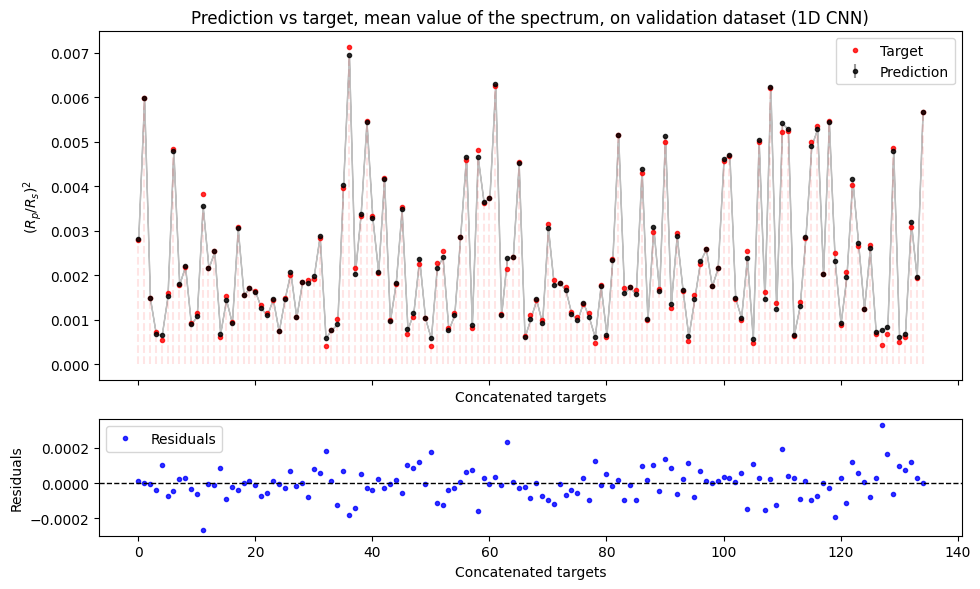

In [35]:
residuals_1dcnn = spectre_valid_wc_1dcnn - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(x = np.arange(len(spectre_valid_wc_1dcnn)), y = spectre_valid_wc_1dcnn, yerr =spectre_valid_std_wc_1dcnn, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc_1dcnn)), spectre_valid_wc_1dcnn - spectre_valid_std_wc_1dcnn, spectre_valid_wc_1dcnn + spectre_valid_std_wc_1dcnn, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc_1dcnn)),ymin=0, ymax=spectre_valid_wc_1dcnn, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset (1D CNN)')
ax1.legend()

ax2.plot(residuals_1dcnn, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()

plt.tight_layout()
plt.show()

#### Erro médio quadrático 1D CNN

In [36]:
MSE_1dcnn = np.sqrt((residuals_1dcnn**2).mean())*1e6

print('MSE (1D CNN) : ', format(MSE_1dcnn, '.4f'), 'ppm')

MSE (1D CNN) :  86.8252 ppm


#### Média das incertezas 1D CNN

In [89]:
mean_uncertainty_1dcnn = np.mean(spectre_valid_std_wc_1dcnn)
print(f"Mean Uncertainty (1D CNN model): {mean_uncertainty_1dcnn:.4e}")

Mean Uncertainty (1D CNN model): 2.5380e-17


#### Plot dos resíduos X incertezas 1D CNN

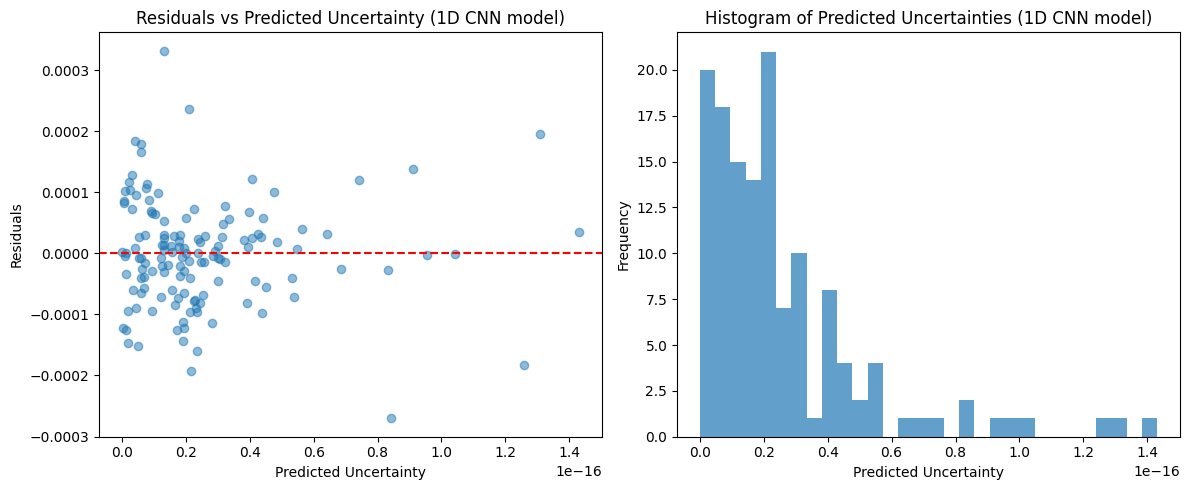

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas, tamanho ajustado

# Gráfico 1: Resíduos vs Incertezas
axes[0].scatter(spectre_valid_std_wc_1dcnn, residuals_1dcnn, alpha=0.5)
axes[0].set_xlabel('Predicted Uncertainty')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted Uncertainty (1D CNN model)')
axes[0].axhline(0, color='red', linestyle='--')
#axes[0].grid()

# Gráfico 2: Histograma das Incertezas
axes[1].hist(spectre_valid_std_wc_1dcnn, bins=30, alpha=0.7)
axes[1].set_xlabel('Predicted Uncertainty')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Predicted Uncertainties (1D CNN model)')
#axes[1].grid()

plt.tight_layout()
plt.show()

#### Salvando os dados do modelo 1D CNN

In [37]:
np.save(f'{output_dir}/pred_valid_wc_1dcnn.npy', spectre_valid_wc_1dcnn)
np.save(f'{output_dir}/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/std_valid_wc_1dcnn.npy', spectre_valid_std_wc_1dcnn)

_________________________________________________________________________________________________________________________________________

## Modelo 1D LSTM

### Estrutura da rede 1D LSTM

In [72]:
# Define as configurações da rede LSTM como um dicionário
def create_model_1D_LSTM(neurons_1, neurons_2, activation, optimizer, dropout_lstm, dropout_dense):
    
    model = Sequential()
    model.add(Input(shape=(187, 1)))
    model.add(LSTM(units=neurons_1, return_sequences=True, dropout=dropout_lstm)) # setar True caso utilização da camada 2 LSTM
    model.add(LSTM(units=neurons_2, return_sequences=False, dropout=dropout_lstm))
    model.add(Dense(64, kernel_initializer='uniform', activation=activation))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

    model.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])  # Define o otimizador Adam
    return model

In [73]:
# Defina os hiperparâmetros
neurons_1 = 64
neurons_2 = 128
activation = 'tanh'
optimizer = 'nadam'
dropout_lstm = 0.2
dropout_dense = 0.1

# Crie o modelo usando a função create_model
model_wc_1dlstm = create_model_1D_LSTM(neurons_1, neurons_2, activation, optimizer, dropout_lstm, dropout_dense)
model_wc_1dlstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 187, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,033 (484.50 KB)

 Trainable params: 124,033 (484.50 KB)

 Non-trainable params: 0 (0.00 B)

### Treinando o modelo 1D LSTM

In [74]:
checkpoint_filepath_1dlstm = 'output/model_1dlstm.keras' 
model_ckt = ModelCheckpoint(
    checkpoint_filepath_1dlstm,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

start_time = time.time()

seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

print('Running ...')
history = model_wc_1dlstm.fit(
    x = train_wc,  
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),  
    batch_size=16,
    epochs= 500,
    shuffle=True,
    verbose=0,
    callbacks=[model_ckt]
    )
print('Done.')

end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo de treinamento: 56 minutos e 30 segundos.


### Avaliação dos resultados 1D LSTM

#### Curvas de erro 1D LSTM

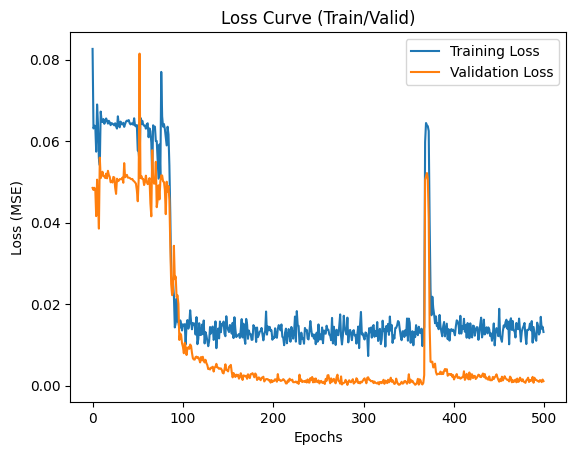

In [75]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve (Train/Valid)') # Adiciona título ao gráfico
plt.xlabel('Epochs') # Adiciona título ao eixo x
plt.ylabel('Loss (MSE)') # Adiciona título ao eixo y
plt.show()

#### Dropout 1D LSTM

In [76]:
#filepath_model_1dlstm = '/kaggle/input/1dlstm_/keras/default/1/model_1dlstm.keras'
#model_wc_1dlstm = load_model(filepath_model_1dlstm)
model_wc_1dlstm = load_model(checkpoint_filepath_1dlstm)

nb_dropout_wc = 200
do_the_mcdropout_wc = True  # Ativa o MC Dropout explicitamente

def unstandardizing (data, min_train_valid, max_train_valid) : 
    return data * (max_train_valid - min_train_valid) + min_train_valid

def MC_dropout_WC (model, data, nb_dropout) : 
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout) : 
        predictions[i,:] = model.predict(data, verbose = 0).flatten()
    return predictions

start_time = time.time()

if do_the_mcdropout_wc :
    print('Running ...')
    prediction_valid_wc_1dlstm = MC_dropout_WC(model_wc_1dlstm, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all_1dlstm = unstandardizing(prediction_valid_wc_1dlstm, min_train_valid_wc, max_train_valid_wc) # desnormalização
    spectre_valid_wc_1dlstm, spectre_valid_std_wc_1dlstm = spectre_valid_wc_all_1dlstm.mean(axis = 0), spectre_valid_wc_all_1dlstm.std(axis = 0)
    print('Done.')

else : 
    spectre_valid_wc_1dlstm = model_wc_1dlstm.predict(valid_wc).flatten()
    spectre_valid_wc_1dlstm = unstandardizing(spectre_valid_wc_1dlstm, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc_1dlstm = 0.1*np.abs(spectre_valid_wc_1dlstm)
    
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo: 1 minutos e 50 segundos.


#### Plot das predições e resíduos 1D LSTM

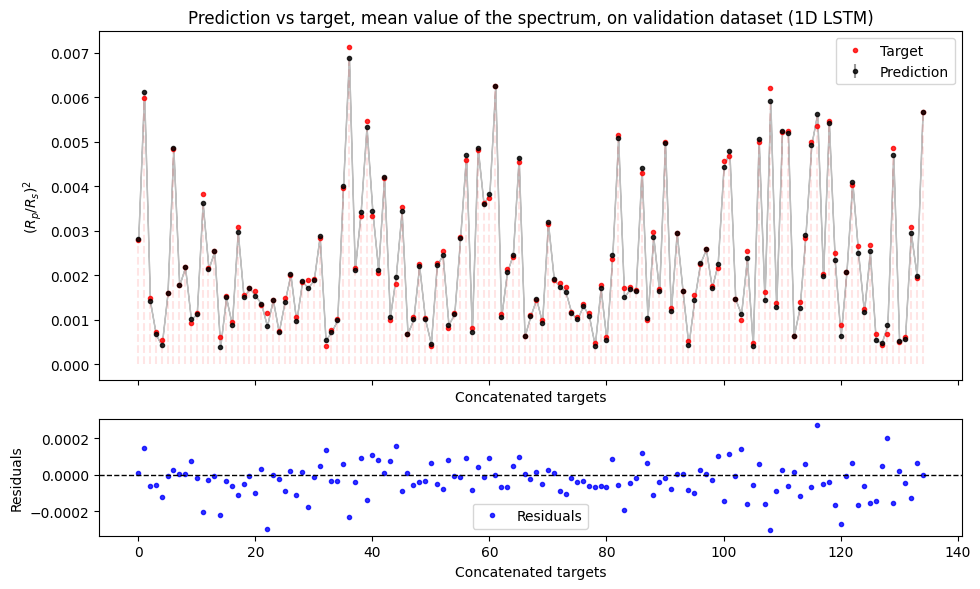

In [77]:
residuals_1dlstm = spectre_valid_wc_1dlstm - valid_targets_wc

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(x = np.arange(len(spectre_valid_wc_1dlstm)), y = spectre_valid_wc_1dlstm, yerr =spectre_valid_std_wc_1dlstm, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc_1dlstm)), spectre_valid_wc_1dlstm - spectre_valid_std_wc_1dlstm, spectre_valid_wc_1dlstm + spectre_valid_std_wc_1dlstm, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc_1dlstm)),ymin=0, ymax=spectre_valid_wc_1dlstm, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset (1D LSTM)')
ax1.legend()

ax2.plot(residuals_1dlstm, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()

plt.tight_layout()
plt.show()

#### Erro quadrático médio 1D LSTM

In [78]:
MSE_1dlstm = np.sqrt((residuals_1dlstm**2).mean())*1e6

print('MSE test (1D LSTM) : ', format(MSE_1dlstm, '.4f'), 'ppm')

MSE test (1D LSTM) :  98.1074 ppm


#### Média das incertezas 1D LSTM

In [90]:
mean_uncertainty_1dlstm = np.mean(spectre_valid_std_wc_1dlstm)
print(f"Mean Uncertainty (1D LSTM model): {mean_uncertainty_1dlstm:.4e}")

Mean Uncertainty (1D LSTM model): 5.7318e-18


#### Plot resíduos X incertezas 1D LSTM

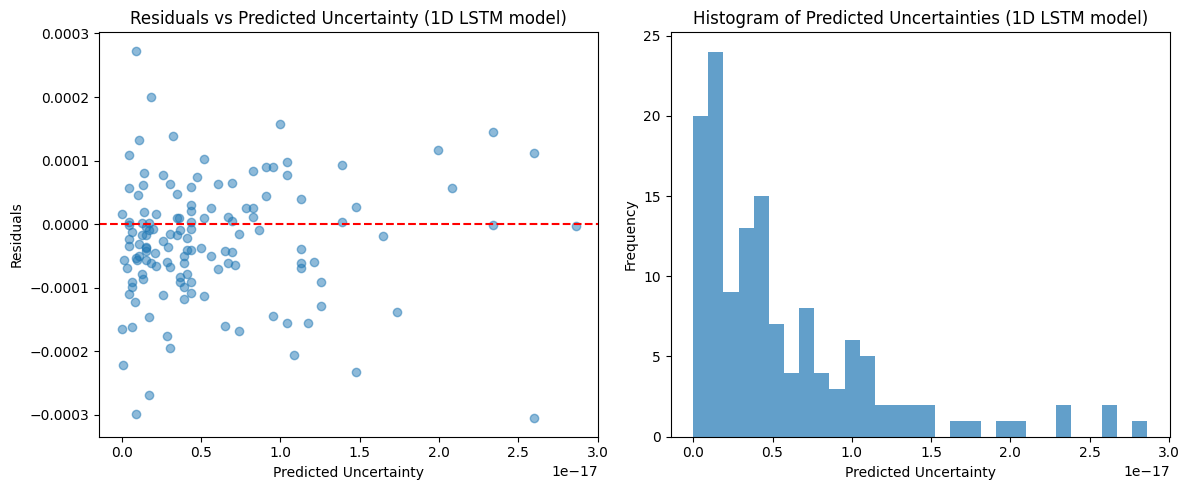

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas, tamanho ajustado

# Gráfico 1: Resíduos vs Incertezas
axes[0].scatter(spectre_valid_std_wc_1dlstm, residuals_1dlstm, alpha=0.5)
axes[0].set_xlabel('Predicted Uncertainty')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted Uncertainty (1D LSTM model)')
axes[0].axhline(0, color='red', linestyle='--')
#axes[0].grid()

# Gráfico 2: Histograma das Incertezas
axes[1].hist(spectre_valid_std_wc_1dlstm, bins=30, alpha=0.7)
axes[1].set_xlabel('Predicted Uncertainty')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Predicted Uncertainties (1D LSTM model)')
#axes[1].grid()

plt.tight_layout()
plt.show()

#### Salvando os dados do modelo 1D LSTM

In [82]:
np.save(f'{output_dir}/pred_valid_wc_1dlstm.npy', spectre_valid_wc_1dlstm)
np.save(f'{output_dir}/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/std_valid_wc_1dlstm.npy', spectre_valid_std_wc_1dlstm)

_________________________________________________________________________________________________________________________________________

## Modelo 1D CNN-LSTM

**Quando Usar TimeDistributed?**

Com Camadas Recorrentes (LSTM, GRU): Quando você tem uma combinação de camadas convolucionais e camadas LSTM (ou outras camadas recorrentes), o uso de TimeDistributed é importante para processar cada "passo temporal" individualmente antes de passar para a camada LSTM.

### Estrutura da rede 1D CNN-LSTM

In [57]:
# Define as configurações da rede LSTM como um dicionário
def create_model_1D_CNN_LSTM(neurons_1, neurons_2, activation, optimizer, dropout_lstm, dropout_dense):
    
    model = Sequential()
    model.add(Input(shape=(187, 1)))
    
    # Camada CNN
    model.add(Conv1D(filters=32, kernel_size=3, activation=activation)) 
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Reshape((-1, 64)))  # -1 é para inferir automaticamente o tamanho dos passos temporais
    
    # Camada LSTM
    model.add(LSTM(units=neurons_1, return_sequences=True, dropout=dropout_lstm)) # setar True caso utilização da camada 2 LSTM
    model.add(LSTM(units=neurons_2, return_sequences=False, dropout=dropout_lstm))
    
    # Camada densa
    model.add(Dense(64, kernel_initializer='uniform', activation=activation))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

    model.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])  # Define o otimizador Adam
    return model

In [58]:
neurons_1 = 64
neurons_2 = 128
activation = 'tanh'
optimizer = 'nadam'
dropout_lstm = 0.2
dropout_dense = 0.1

# Crie o modelo usando a função create_model
model_wc_1dcnn_lstm = create_model_1D_CNN_LSTM(neurons_1, neurons_2, activation, optimizer, dropout_lstm, dropout_dense)
model_wc_1dcnn_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 185, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 90, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 90, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 45, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,881 (573.75 KB)

 Trainable params: 146,689 (573.00 KB)

 Non-trainable params: 192 (768.00 B)

### Treinamento do modelo 1D CNN-LSTM

In [59]:
checkpoint_filepath_1dcnn_lstm = 'output/model_1dcnn_lstm.keras' 

model_ckt = ModelCheckpoint(
    checkpoint_filepath_1dcnn_lstm,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

start_time = time.time()

seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

print('Running ...')
history = model_wc_1dcnn_lstm.fit(
    x = train_wc,  
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),  
    batch_size=64,
    epochs= 600,
    shuffle=True,
    verbose=0,
    callbacks=[model_ckt]
    )
print('Done.')

end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo de treinamento: 10 minutos e 27 segundos.


### Avaliação dos resultados 1D CNN-LSTM

#### Curvas de erro 1D CNN-LSTM

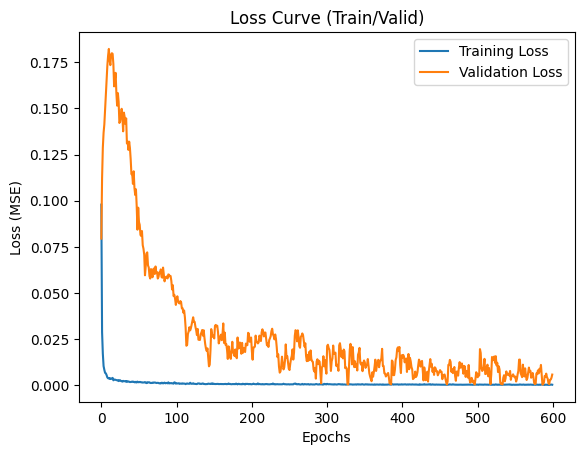

In [62]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve (Train/Valid)') # Adiciona título ao gráfico
plt.xlabel('Epochs') # Adiciona título ao eixo x
plt.ylabel('Loss (MSE)') # Adiciona título ao eixo y
plt.show()

#### Dropout 1D CNN-LSTM

In [66]:
filepath_1dcnn_lstm = '/kaggle/input/1dcnn_lstm_/keras/default/1/model_1dcnn_lstm.keras'
model_wc_1dcnn_lstm = load_model(filepath_1dcnn_lstm)
#model_wc_1dcnn_lstm = load_model(checkpoint_filepath_1dcnn_lstm)

nb_dropout_wc = 200
do_the_mcdropout_wc = True  # Ativa o MC Dropout explicitamente

def unstandardizing (data, min_train_valid, max_train_valid) : 
    return data * (max_train_valid - min_train_valid) + min_train_valid

def MC_dropout_WC (model, data, nb_dropout) : 
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout) : 
        predictions[i,:] = model.predict(data, verbose = 0).flatten()
    return predictions

start_time = time.time()

if do_the_mcdropout_wc :
    print('Running ...')
    prediction_valid_wc_1dcnn_lstm = MC_dropout_WC(model_wc_1dcnn_lstm, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all_1dcnn_lstm = unstandardizing(prediction_valid_wc_1dcnn_lstm, min_train_valid_wc, max_train_valid_wc) # desnormalização
    spectre_valid_wc_1dcnn_lstm, spectre_valid_std_wc_1dcnn_lstm = spectre_valid_wc_all_1dcnn_lstm.mean(axis = 0), spectre_valid_wc_all_1dcnn_lstm.std(axis = 0)
    print('Done.')

else : 
    spectre_valid_wc_1dcnn_lstm = model_wc_1dcnn_lstm.predict(valid_wc).flatten()
    spectre_valid_wc_1dcnn_lstm = unstandardizing(spectre_valid_wc_1dcnn_lstm, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc_1dcnn_lstm = 0.1*np.abs(spectre_valid_wc)
    
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo de treinamento: 0 minutos e 44 segundos.


#### Plot das predições e resíduos 1D CNN-LSTM

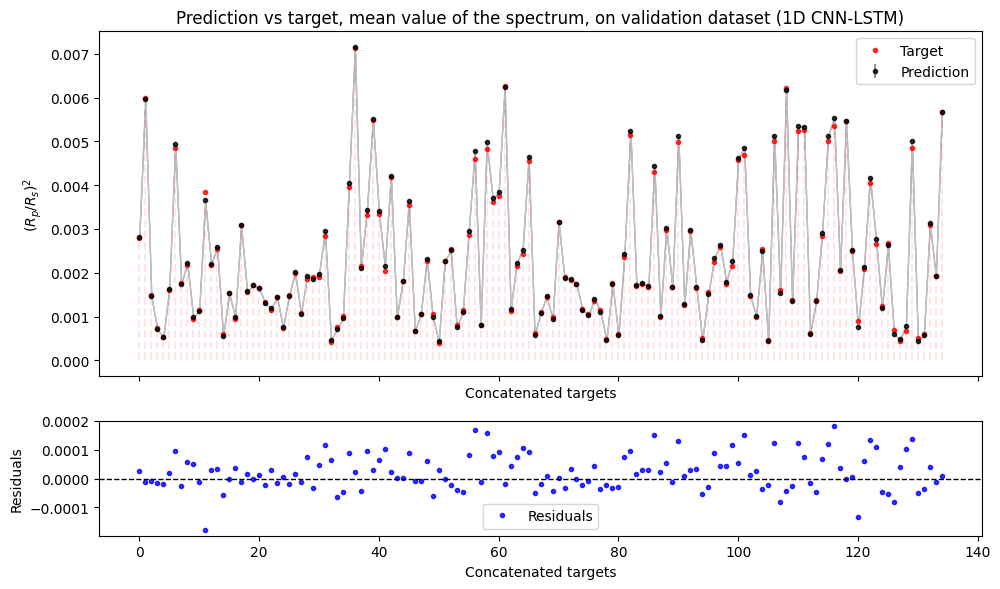

In [67]:
residuals_1dcnn_lstm = spectre_valid_wc_1dcnn_lstm - valid_targets_wc

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(x = np.arange(len(spectre_valid_wc_1dcnn_lstm)), y = spectre_valid_wc_1dcnn_lstm, yerr =spectre_valid_std_wc_1dcnn_lstm, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc_1dcnn_lstm)), spectre_valid_wc_1dcnn_lstm - spectre_valid_std_wc_1dcnn_lstm, spectre_valid_wc_1dcnn_lstm + spectre_valid_std_wc_1dcnn_lstm, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc_1dcnn_lstm)),ymin=0, ymax=spectre_valid_wc_1dcnn_lstm, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset (1D CNN-LSTM)')
ax1.legend()

ax2.plot(residuals_1dcnn_lstm, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()

plt.tight_layout()
plt.show()

#### Erro médio quadrático 1D CNN-LSTM

In [83]:
MSE_1dcnn_lstm = np.sqrt((residuals_1dcnn_lstm**2).mean())*1e6

print('MSE (1D CNN-LSTM) : ', format(MSE_1dcnn_lstm, '.4f'), 'ppm')

MSE (1D CNN-LSTM) :  65.9902 ppm


#### Média das incertezas 1D CNN-LSTM

In [135]:
mean_uncertainty_1dcnn_lstm = np.mean(spectre_valid_std_wc_1dcnn_lstm)
print(f"Mean Uncertainty (1D CNN-LSTM model): {mean_uncertainty_1dcnn_lstm:.4e}")

Mean Uncertainty (1D CNN-LSTM model): 5.3636e-18


#### Plot dos resíduos X incertezas 1D CNN-LSTM

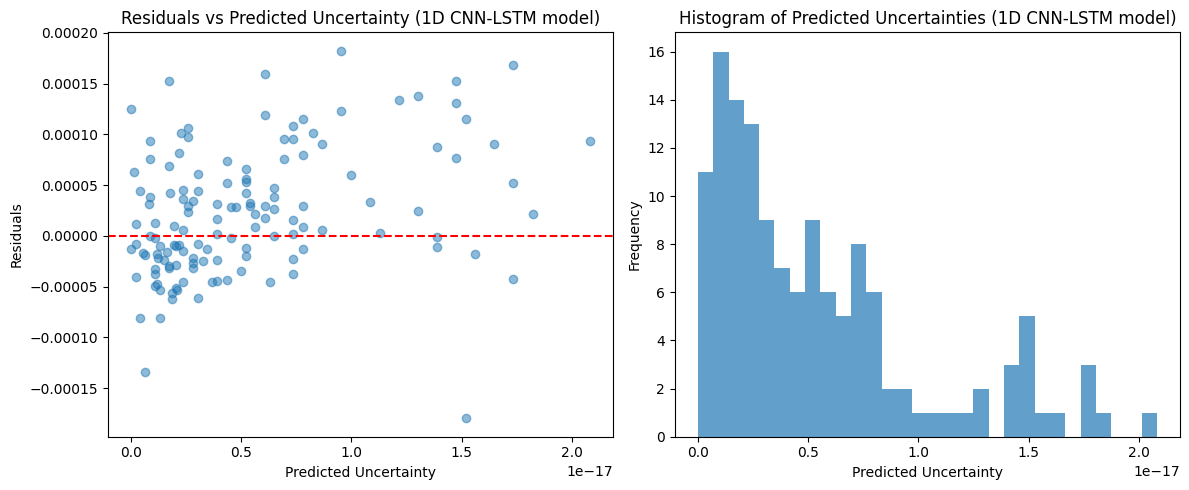

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas, tamanho ajustado

# Gráfico 1: Resíduos vs Incertezas
axes[0].scatter(spectre_valid_std_wc_1dcnn_lstm, residuals_1dcnn_lstm, alpha=0.5)
axes[0].set_xlabel('Predicted Uncertainty')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted Uncertainty (1D CNN-LSTM model)')
axes[0].axhline(0, color='red', linestyle='--')
#axes[0].grid()

# Gráfico 2: Histograma das Incertezas
axes[1].hist(spectre_valid_std_wc_1dcnn_lstm, bins=30, alpha=0.7)
axes[1].set_xlabel('Predicted Uncertainty')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Predicted Uncertainties (1D CNN-LSTM model)')
#axes[1].grid()

plt.tight_layout()
plt.show()

#### Salvando os dados do modelo 1D CNN-LSTM

In [69]:
np.save(f'{output_dir}/pred_valid_wc_1dcnn_lstm.npy', spectre_valid_wc_1dcnn_lstm)
np.save(f'{output_dir}/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/std_valid_wc_1dcnn_lstm.npy', spectre_valid_std_wc_1dcnn_lstm)

_________________________________________________________________________________________________________________________________________

# Redes 2D para características atmosféricas

## Pré-processamento para modelos 2D

In [16]:
def suppress_mean(targets, mean) : 
    res = targets - np.repeat(mean.reshape((mean.shape[0], 1)), repeats = targets.shape[1], axis = 1)
    return res
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

train_targets_shift = suppress_mean(train_targets,  targets_mean[list_index_train]) # lembrando que targets_mean tem inicialmente shape(673)
valid_targets_shift = suppress_mean(valid_targets,  targets_mean[~list_index_train])

In [17]:
##### normalization of the targets ###
def targets_normalization (data1, data2) : 
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max

def targets_norm_back (data, data_abs_max) : 
    return data * data_abs_max

train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(train_targets_shift, valid_targets_shift)

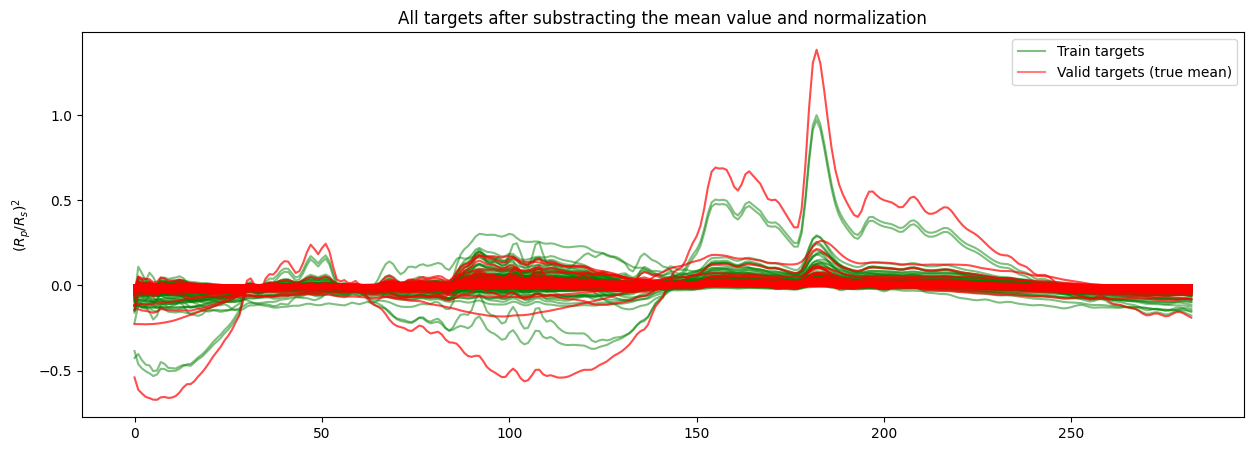

In [18]:
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets_norm[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) : 
    plt.plot(wls, valid_targets_norm[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('All targets after substracting the mean value and normalization')
plt.show()

In [19]:
###### Transpose #####
train_obs = train_obs.transpose(0, 2, 1)
valid_obs = valid_obs.transpose(0, 2, 1)
print(train_obs.shape)

(538, 187, 283)


In [20]:
##### Substracting the out transit signal #####
def suppress_out_transit (data, ingress, egress) : 
    data_in = data[:, ingress:egress,:]
    return data_in

ingress, egress = 75,115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)

In [21]:
###### Substract the mean #####
def substract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean() # subtrai a média calculada de cada uma das 283 colunas do espectro correspondente, para cada um dos 40 passos de tempo.
    return data_mean

train_obs_2d_mean = substract_data_mean(train_obs_in)
valid_obs_2d_mean = substract_data_mean(valid_obs_in)

In [22]:
##### Normalization dataset #####
def data_norm(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max


def data_normback(data, data_abs_max) : 
    return data * data_abs_max

train_obs_norm, valid_obs_norm, data_abs_max = data_norm(train_obs_2d_mean, valid_obs_2d_mean)

print('train_obs_norm shape: ',train_obs_norm.shape)
print('valid_obs_norm shape: ',valid_obs_norm.shape)
print('train_targets shape: ',train_targets.shape)
print('valid_targets shape: ',valid_targets.shape)

train_obs_norm shape:  (538, 40, 283)
valid_obs_norm shape:  (135, 40, 283)
train_targets shape:  (538, 283)
valid_targets shape:  (135, 283)


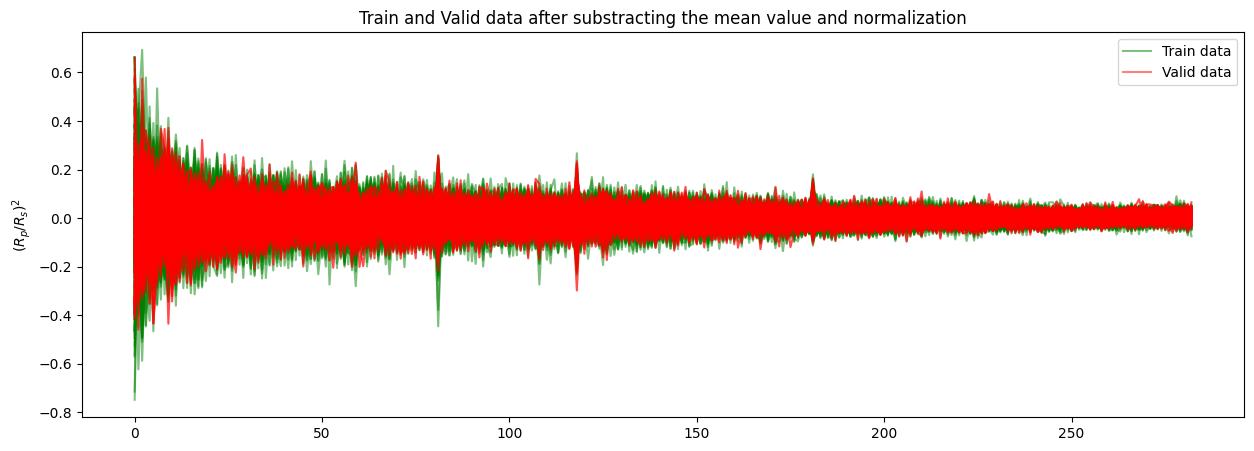

In [23]:
plt.figure(figsize=(15,5))
for i in range (train_obs.shape[0]) :
    plt.plot(wls, train_obs_norm[i,10], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train data')
for i in range (valid_obs.shape[0]) : 
    plt.plot(wls, valid_obs_norm[i,10], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid data')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Train and Valid data after substracting the mean value and normalization')
plt.show()

_________________________________________________________________________________________________________________________________________

## Modelo 2D CNN

### Estrutura da rede 2D CNN

In [39]:
input_obs = Input((40,283,1))
x = Conv2D(32, (3, 1), activation='relu', padding='same')(input_obs)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(128, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(256, (3, 1), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(128, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(256, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Flatten()(x)
x = Dense(700, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
output = Dense(283, activation='linear')(x)

model_2dcnn = Model(inputs=[input_obs], outputs=output)
model_2dcnn.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 40, 283, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 283, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 283, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 283, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 283, 64)    │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 283, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 283, 128)   │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 283, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 283, 256)    │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 283, 32)     │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 141, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 141, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 141, 64)     │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 70, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 70, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 35, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 35, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 17, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 700)            │    15,232,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 283)            │       198,383 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,715,019 (59.95 MB)

 Trainable params: 15,714,891 (59.95 MB)

 Non-trainable params: 128 (512.00 B)

### Treinando modelo 2D CNN

In [58]:
optimizer=Adam(0.001)
model_2dcnn.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])

checkpoint_filepath_2dcnn = 'output/model_2dcnn.keras'
model_ckt2 = ModelCheckpoint(
    checkpoint_filepath_2dcnn,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

start_time = time.time()

seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

print('Running ...')
history = model_2dcnn.fit(
     x = train_obs_norm,  
     y = train_targets_norm,
     validation_data = (valid_obs_norm, valid_targets_norm),  
     batch_size=32,
     epochs= 200,
     shuffle=True,
     verbose=0,
    callbacks=[model_ckt2]
 )
print('Done.')

end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo de treinamento: 98 minutos e 32 segundos.


### Avaliação dos resultados 2D CNN

#### Curvas de erro 2D CNN

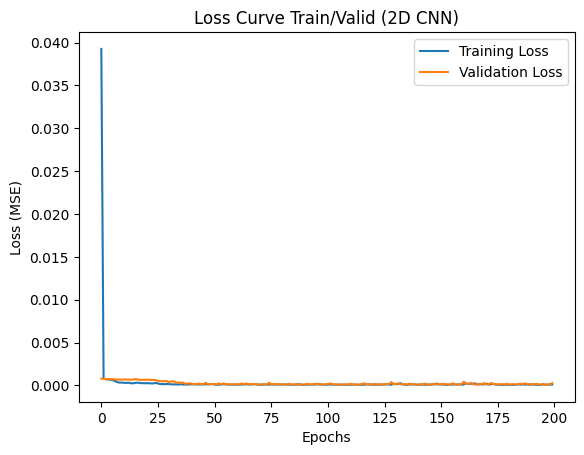

In [59]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve Train/Valid (2D CNN)') 
plt.xlabel('Epochs') 
plt.ylabel('Loss (MSE)') 
plt.show()

#### Dropout 2D CNN

In [42]:
filepath_model_2dcnn = '/kaggle/input/2dcnn_/keras/default/1/model_2dcnn.keras' # substituir caminho abaixo para carregar modelo treinado
model_2dcnn = load_model(filepath_model_2dcnn)

#model_2dcnn = load_model(checkpoint_filepath_2dcnn)

nb_dropout = 5
do_the_mcdropout_2dcnn = True

start_time = time.time()

def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model.predict([x_test],verbose=0)
        pred = targets_norm_back(pred_norm, targets_abs_max) # desnormalização
        predictions += [pred]  
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout_2dcnn:
    print('Running ...')
    spectre_valid_shift_2dcnn, spectre_valid_shift_std_2dcnn = NN_uncertainity(model_2dcnn, [valid_obs_norm], targets_abs_max, T = nb_dropout)
    
else :

    pred_valid_norm_2dcnn = model_2dcnn.predict([valid_obs_norm])
    pred_valid_2dcnn = targets_norm_back(pred_valid_norm_2dcnn, targets_abs_max)
    spectre_valid_shift_2dcnn = pred_valid_2dcnn
    spectre_valid_shift_std_2dcnn = spectre_valid_shift_2dcnn*0.1
    
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Tempo de treinamento: 0 minutos e 7 segundos.


#### Erro médio quadrático 2D CNN

In [43]:
residuals_2dcnn = valid_targets_shift - spectre_valid_shift_2dcnn
MSE_2dcnn = np.sqrt((residuals_2dcnn**2).mean())*1e6

print('MSE (2D CNN) : ', format(MSE_2dcnn, '.4f'), 'ppm')

MSE (2D CNN) :  40.1951 ppm


#### Média das incertezas 2D CNN

In [112]:
mean_uncertainty_2dcnn = np.mean(spectre_valid_shift_std_2dcnn)
print(f"Mean Uncertainty (2D CNN model): {mean_uncertainty_2dcnn:.4e}")

Mean Uncertainty (2D CNN model): 2.2545e-13


#### Plot dos espectros preditos pelo modelo 2D CNN

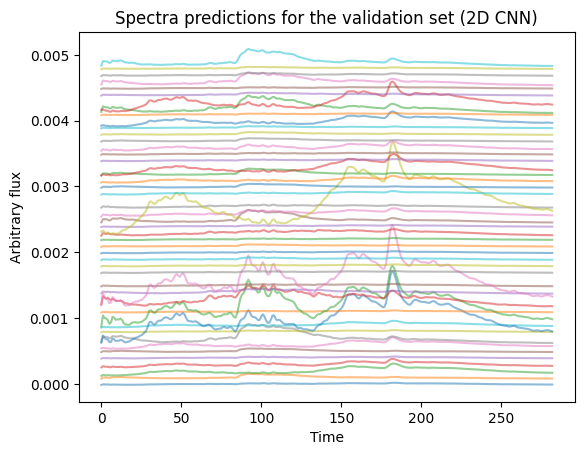

In [107]:
plt.figure()
for i in range (50) : 
    plt.plot(spectre_valid_shift_2dcnn[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set (2D CNN)') 
plt.xlabel('Time')
plt.ylabel('Arbitrary flux')
plt.show()

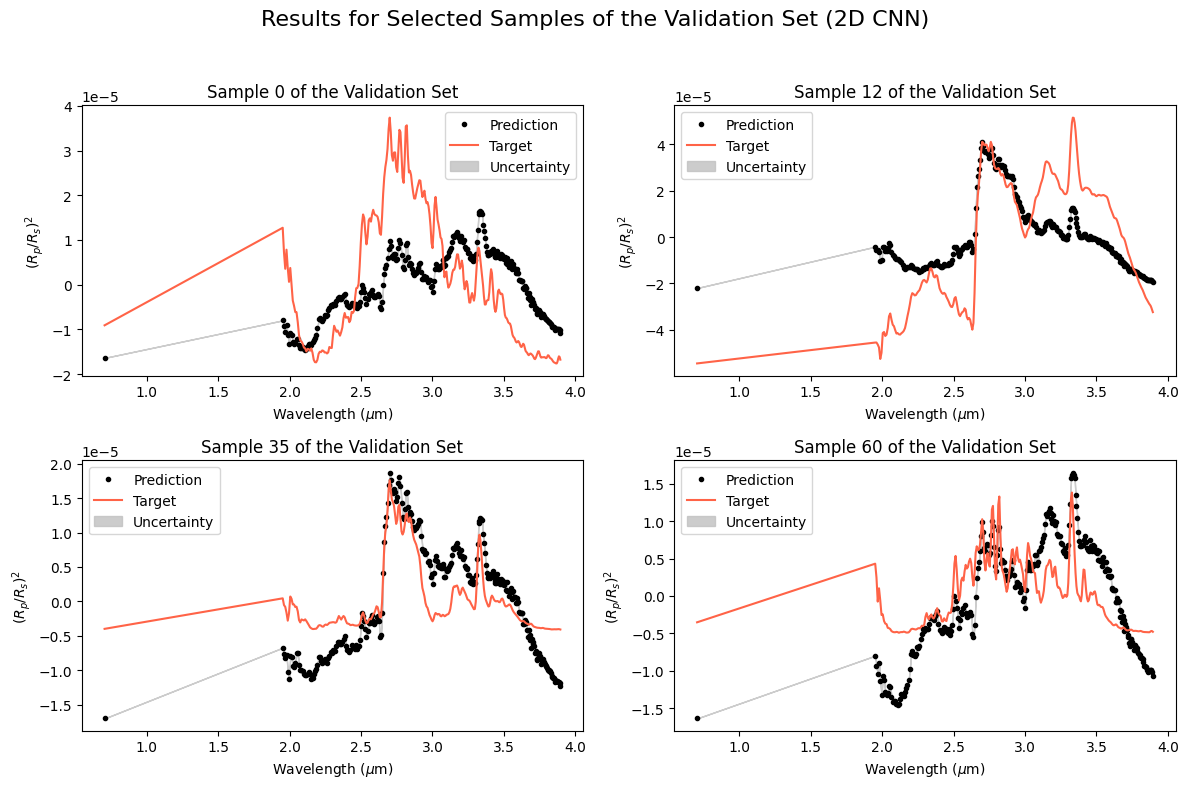

In [133]:
list_valid_planets = [0, 12, 35, 60]
wavelength = np.loadtxt('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter=',')
uncertainty_2dcnn = spectre_valid_shift_std_2dcnn

# Configura o grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Tamanho da figura ajustado para melhor visualização
fig.suptitle("Results for Selected Samples of the Validation Set (2D CNN)", fontsize=16)

# Itera pelos planetas e subplots
for idx, planet in enumerate(list_valid_planets):
    ax = axes[idx // 2, idx % 2]  # Acessa a posição correta no grid
    ax.set_title(f'Sample {planet} of the Validation Set')
    ax.plot(wavelength, spectre_valid_shift_2dcnn[planet], '.k', label='Prediction')
    ax.plot(wavelength, valid_targets_shift[planet], color='tomato', label='Target')
    ax.fill_between(
        wavelength,
        spectre_valid_shift_2dcnn[planet] - spectre_valid_shift_std_2dcnn[planet],
        spectre_valid_shift_2dcnn[planet] + spectre_valid_shift_std_2dcnn[planet],
        color='silver',
        alpha=0.8,
        label='Uncertainty'
    )
    ax.legend()
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deixa espaço para o título geral
plt.show()

#### Salvando os dados 2D CNN

In [46]:
np.save(f'{output_dir}/pred_valid_shift_2dcnn.npy', spectre_valid_shift_2dcnn)
np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_shift)
np.save(f'{output_dir}/std_valid_shift_2dcnn.npy', spectre_valid_shift_std_2dcnn)

_________________________________________________________________________________________________________________________________________

## Modelo 2D LSTM

### Estrutura da rede 2D LSTM

In [86]:
def create_model_2D_LSTM(neurons_1, neurons_2, activation, optimizer, dropout):
    
    model = Sequential()
    model.add(Input(shape=(40, 283))) # Input layer

    # LSTM para modelar dependências temporais
    model.add(LSTM(units=neurons_1, return_sequences=True,dropout=dropout))  
    model.add(LSTM(units=neurons_2, return_sequences=False, dropout=dropout))  
    
    # Camada densa final para prever os 283 comprimentos de onda
    model.add(Dense(512, kernel_initializer='uniform', activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(283, kernel_initializer='uniform', activation='linear')) # Output layer

    # Compilação do modelo
    model.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])
    
    return model

In [87]:
# Defina os hiperparâmetros
neurons_1 = 128
neurons_2 = 256
activation = 'tanh' # original: relu
optimizer = 'nadam' 
dropout = 0.2

# Crie o modelo usando a função create_model
model_2dlstm = create_model_2D_LSTM(neurons_1, neurons_2, activation, optimizer, dropout)
model_2dlstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 40, 128)        │       210,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 283)            │       145,179 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 881,947 (3.36 MB)

 Trainable params: 881,947 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

### Treinando o modelo 2D LSTM

In [92]:
checkpoint_filepath_2dlstm = 'output/model_2dlstm.keras' 
model_ckt = ModelCheckpoint(
    checkpoint_filepath_2dlstm,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

start_time = time.time()

seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

print('Running ...')
history = model_2dlstm.fit(
    train_obs_norm,  # Dados de entrada de treino (538, 40, 283)
    train_targets_norm,  # Alvos de treino (538, 283)
    validation_data = (valid_obs_norm, valid_targets_norm),  
    batch_size=16, # TESTAR COM BATCH MAIOR
    epochs= 500,
    shuffle=True,
    verbose=0,
    callbacks=[model_ckt]
    )
print('Done.')

end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Done.
Tempo de treinamento: 30 minutos e 38 segundos.


### Avaliação dos resultados 2D LSTM

#### Curvas de erro 2D LSTM

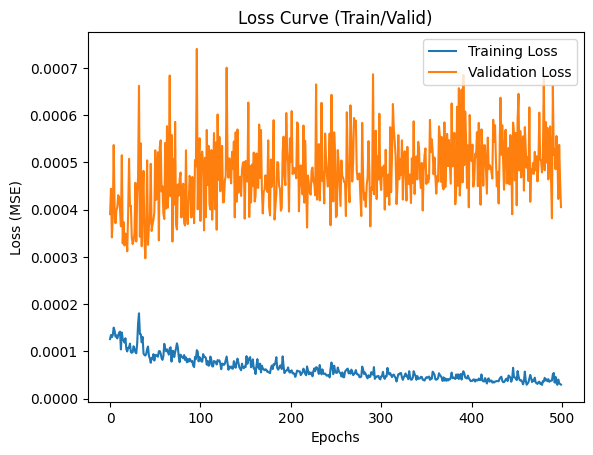

In [93]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve (Train/Valid)') # Adiciona título ao gráfico
plt.xlabel('Epochs') # Adiciona título ao eixo x
plt.ylabel('Loss (MSE)') # Adiciona título ao eixo y
plt.show()

#### Dropout 2D LSTM

In [94]:
# Carrega o melhor modelo
model_2dlstm = load_model(checkpoint_filepath_2dlstm)

nb_dropout = 5
do_the_mcdropout = True

start_time = time.time()

def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model.predict([x_test],verbose=0)
        pred = targets_norm_back(pred_norm, targets_abs_max) # desnormalização
        predictions += [pred]  
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout :
    print('Running ...')
    # predições dos espectros e das incertezas
    spectre_valid_shift_2dlstm, spectre_valid_shift_std_2dlstm = NN_uncertainity(model_2dlstm, [valid_obs_norm], targets_abs_max, T = nb_dropout)
    
else :

    pred_valid_norm_2dlstm = model_2dlstm.predict([valid_obs_norm])
    pred_valid_2dlstm = targets_norm_back(pred_valid_norm_2dlstm, targets_abs_max)
    spectre_valid_shift_2dlstm = pred_valid_2dlstm
    spectre_valid_shift_std_2dlstm = spectre_valid_shift_2dlstm*0.1
    
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Tempo de treinamento: 0 minutos e 2 segundos.


#### Erro médio quadrático 2D LSTM

In [95]:
residuals_2dlstm = valid_targets_shift - spectre_valid_shift_2dlstm
MSE_2dlstm = np.sqrt((residuals_2dlstm**2).mean())*1e6

print('MSE (2D LSTM) : ', format(MSE_2dlstm, '.4f'), 'ppm')

MSE (2D LSTM) :  38.0025 ppm


#### Média das incertezas 2D LSTM

In [132]:
mean_uncertainty_2dlstm = np.mean(spectre_valid_shift_std_2dlstm)
print(f"Mean Uncertainty (2D LSTM model): {mean_uncertainty_2dlstm:.4e}")

Mean Uncertainty (2D LSTM model): 3.1249e-13


#### Plot dos espectros preditos pelo modelo 2D LSTM

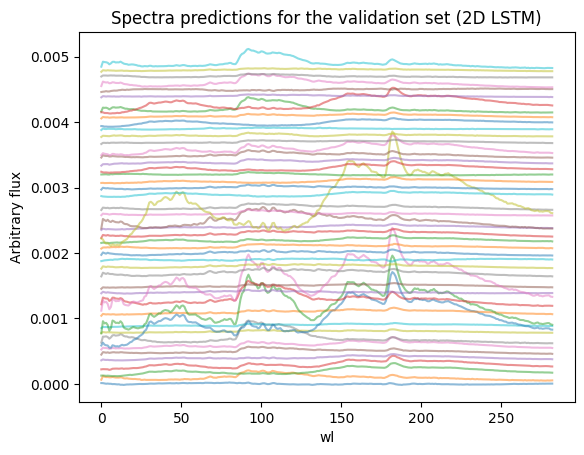

In [137]:
plt.figure()
for i in range (50) : 
    plt.plot(spectre_valid_shift_2dlstm[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set (2D LSTM)') 
plt.xlabel('wl')
plt.ylabel('Arbitrary flux')
plt.show()

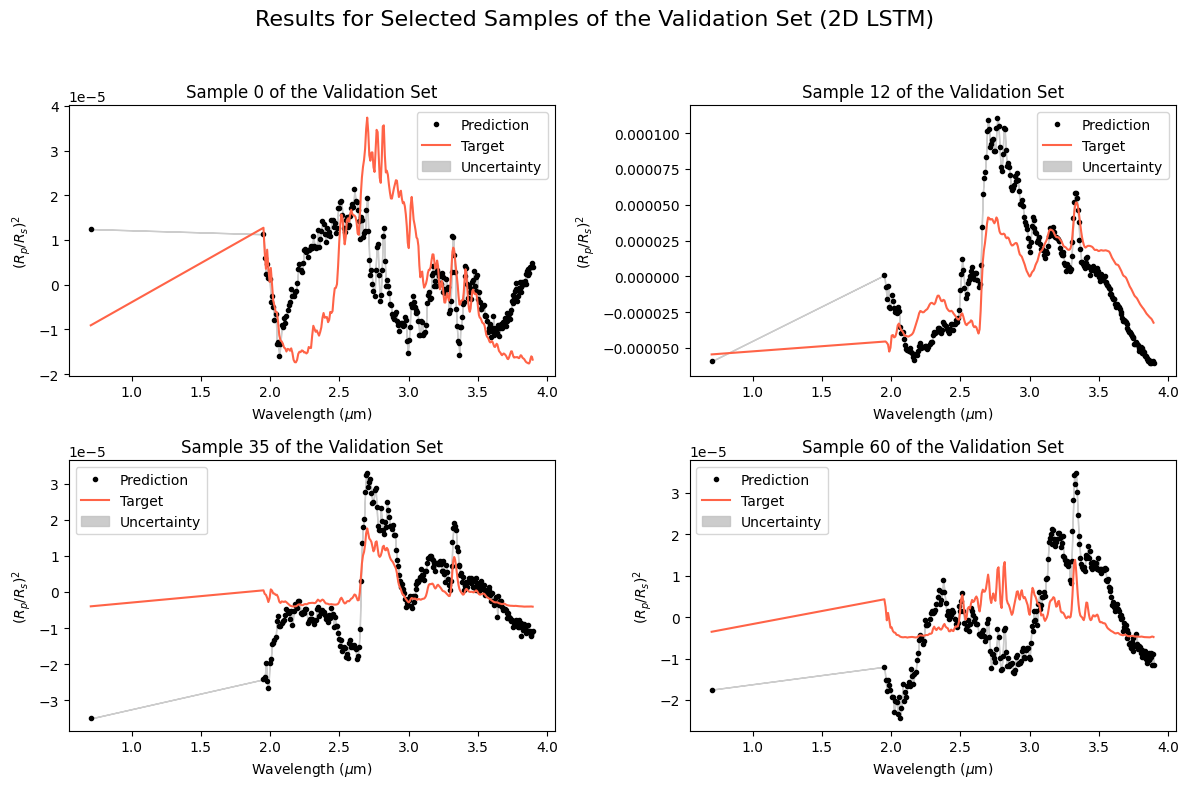

In [130]:
list_valid_planets = [0, 12, 35, 60]
wavelength = np.loadtxt('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter=',')
uncertainty_2dlstm = spectre_valid_shift_std_2dlstm

# Configura o grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Tamanho da figura ajustado para melhor visualização
fig.suptitle("Results for Selected Samples of the Validation Set (2D LSTM)", fontsize=16)

# Itera pelos planetas e subplots
for idx, planet in enumerate(list_valid_planets):
    ax = axes[idx // 2, idx % 2]  # Acessa a posição correta no grid
    ax.set_title(f'Sample {planet} of the Validation Set')
    ax.plot(wavelength, spectre_valid_shift_2dlstm[planet], '.k', label='Prediction')
    ax.plot(wavelength, valid_targets_shift[planet], color='tomato', label='Target')
    ax.fill_between(
        wavelength,
        spectre_valid_shift_2dlstm[planet] - spectre_valid_shift_std_2dlstm[planet],
        spectre_valid_shift_2dlstm[planet] + spectre_valid_shift_std_2dlstm[planet],
        color='silver',
        alpha=0.8,
        label='Uncertainty'
    )
    ax.legend()
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deixa espaço para o título geral
plt.show()

#### Salvando os dados 2D LSTM

In [124]:
np.save(f'{output_dir}/pred_valid_2dlstm.npy', spectre_valid_shift_2dlstm)
np.save(f'{output_dir}/targ_valid_2d.npy', valid_targets_shift)
np.save(f'{output_dir}/std_valid_2dlstm.npy', spectre_valid_shift_std_2dlstm)

_________________________________________________________________________________________________________________________________________

## Modelo 2D CNN-LSTM

### Estrutura da rede 2D CNN-LSTM

Quando você tem uma combinação de camadas convolucionais e camadas LSTM (ou outras camadas recorrentes), o uso de TimeDistributed é importante para processar cada "passo temporal" individualmente antes de passar para a camada LSTM.

In [139]:
from tensorflow.keras import Input, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import MeanAbsoluteError

def create_model_2DCNN_LSTM(neurons_1, activation, optimizer):
    model = Sequential()
    model.add(Input(shape=(40, 283, 1))) # Input layer
    
    # CNN para extrair características dos comprimentos de onda
    model.add(layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=3, activation='relu')))  # input_shape = (40, 283)
    model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
    model.add(layers.TimeDistributed(layers.Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
    model.add(layers.TimeDistributed(layers.Flatten()))  # Achata o resultado da CNN para alimentar na LSTM

    # LSTM para modelar dependências temporais
    model.add(layers.LSTM(units=neurons_1, activation=activation, return_sequences=False))  # Return_sequences=False, pois estamos prevendo um único alvo
    
    # Camada densa final para prever os 283 comprimentos de onda
    model.add(layers.Dense(283, activation='linear'))

    # Compilação do modelo
    model.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])
    
    return model

In [140]:
neurons_1 = 128
activation = 'relu'
optimizer = 'nadam'

model_2dcnn_lstm = create_model_2DCNN_LSTM(neurons_1, activation, optimizer)

### Treinando o modelo 2D CNN-LSTM

In [141]:
start_time = time.time()

checkpoint_filepath_2dcnn_lstm = 'output/model_2dcnn_lstm.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath_2dcnn_lstm,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

history = model_2dcnn_lstm.fit(
    train_obs_norm,  
    train_targets_norm,  
    validation_data=(valid_obs_norm, valid_targets_norm), 
    epochs=200,
    batch_size=16,
    shuffle=True,
    verbose=0,
    callbacks=[model_ckt]
)

end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Tempo de treinamento: 198 minutos e 44 segundos.


### Avaliação dos resultados para 2D CNN-LSTM

#### Curvas de erro 2D CNN-LSTM

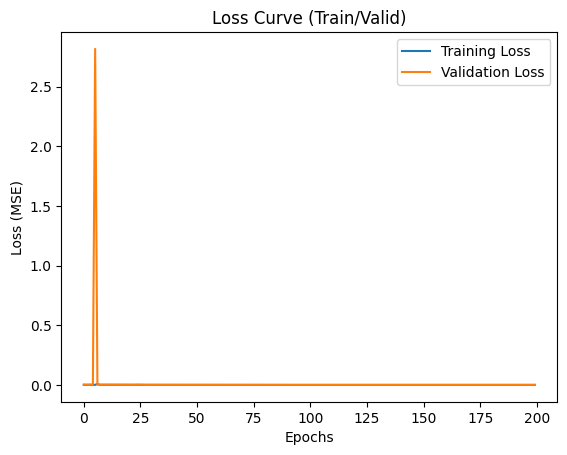

In [142]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve (Train/Valid)') 
plt.xlabel('Epochs') 
plt.ylabel('Loss (MSE)') 
plt.show()

#### Dropout do modelo 2D CNN-LSTM

In [143]:
filepath_model_2dcnn_lstm = '/kaggle/input/2dcnn_lstm/keras/default/1/model_2dcnn_lstm.keras' # substituir caminho abaixo para carregar modelo treinado
#model_2dcnn_lstm = load_model(filepath_model_2dcnn_lstm)
model_2dcnn_lstm = load_model(checkpoint_filepath_2dcnn_lstm)

nb_dropout = 5
do_the_mcdropout_2dcnn_lstm = True

start_time = time.time()

def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model.predict([x_test],verbose=0)
        pred = targets_norm_back(pred_norm, targets_abs_max) # desnormalização
        predictions += [pred]  
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout_2dcnn_lstm:
    print('Running ...')
    spectre_valid_shift_2dcnn_lstm, spectre_valid_shift_std_2dcnn_lstm = NN_uncertainity(model_2dcnn_lstm, [valid_obs_norm], targets_abs_max, T = nb_dropout)
    
else :

    pred_valid_norm = model_2dcnn_lstm.predict([valid_obs_norm])
    pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
    spectre_valid_shift_2dcnn_lstm = pred_valid
    spectre_valid_shift_std_2dcnn_lstm = spectre_valid_shift_2dcnn_lstm*0.1
    
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tempo de treinamento: {minutes} minutos e {seconds} segundos.")

Running ...
Tempo de treinamento: 0 minutos e 8 segundos.


#### Erro médio quadrático 2D CNN-LSTM

In [144]:
residuals_2dcnn_lstm = valid_targets_shift - spectre_valid_shift_2dcnn_lstm
MSE_2dcnn_lstm = np.sqrt((residuals_2dcnn_lstm**2).mean())*1e6

print('MSE (2D CNN-LSTM) : ', format(MSE_2dcnn_lstm, '.4f'), 'ppm')

MSE (2D CNN-LSTM) :  31.5257 ppm


#### Média das incertezas 2D CNN-LSTM

In [145]:
mean_uncertainty_2dcnn_lstm = np.mean(spectre_valid_shift_std_2dcnn_lstm)
print(f"Mean Uncertainty (2D CNN-LSTM model): {mean_uncertainty_2dcnn_lstm:.4e}")

Mean Uncertainty (2D CNN-LSTM model): 3.0072e-13


#### Plot dos espectros preditos 2D CNN-LSTM

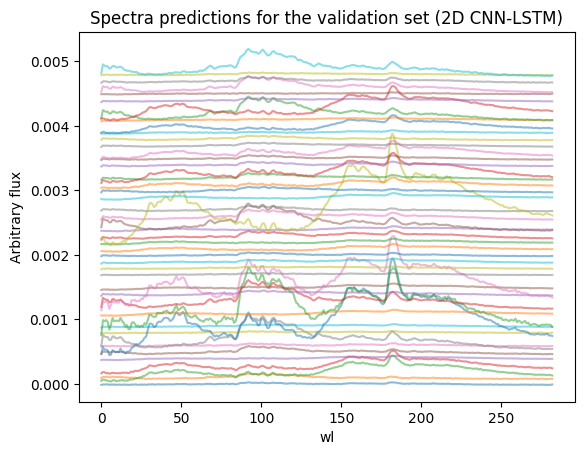

In [147]:
plt.figure()
for i in range (50) : 
    plt.plot(spectre_valid_shift_2dcnn_lstm[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set (2D CNN-LSTM)') 
plt.xlabel('wl')
plt.ylabel('Arbitrary flux')
plt.show()

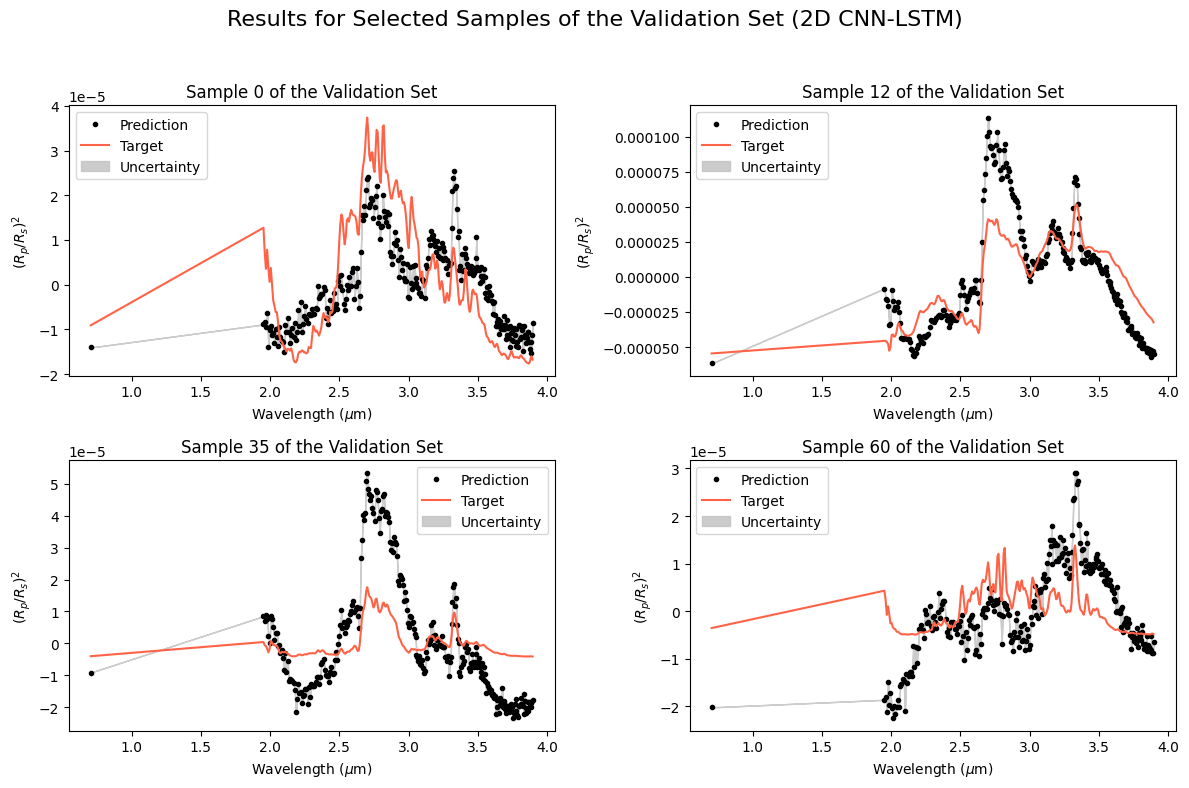

In [148]:
list_valid_planets = [0, 12, 35, 60]
wavelength = np.loadtxt('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter=',')
uncertainty_2dcnn_lstm = spectre_valid_shift_std_2dcnn_lstm

# Configura o grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Tamanho da figura ajustado para melhor visualização
fig.suptitle("Results for Selected Samples of the Validation Set (2D CNN-LSTM)", fontsize=16)

# Itera pelos planetas e subplots
for idx, planet in enumerate(list_valid_planets):
    ax = axes[idx // 2, idx % 2]  # Acessa a posição correta no grid
    ax.set_title(f'Sample {planet} of the Validation Set')
    ax.plot(wavelength, spectre_valid_shift_2dcnn_lstm[planet], '.k', label='Prediction')
    ax.plot(wavelength, valid_targets_shift[planet], color='tomato', label='Target')
    ax.fill_between(
        wavelength,
        spectre_valid_shift_2dcnn_lstm[planet] - spectre_valid_shift_std_2dcnn_lstm[planet],
        spectre_valid_shift_2dcnn_lstm[planet] + spectre_valid_shift_std_2dcnn_lstm[planet],
        color='silver',
        alpha=0.8,
        label='Uncertainty'
    )
    ax.legend()
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deixa espaço para o título geral
plt.show()

#### Salvando os dados 2D CNN-LSTM

In [149]:
np.save(f'{output_dir}/pred_valid_2dcnn_lstm.npy', spectre_valid_shift_2dcnn_lstm)
np.save(f'{output_dir}/targ_valid_2d.npy', valid_targets_shift)
np.save(f'{output_dir}/std_valid_2dcnn_lstm.npy', spectre_valid_shift_std_2dcnn_lstm)

_________________________________________________________________________________________________________________________________________

# Combinando melhores modelos 1D e 2D para espectro final

## Modelo LSTM

#### Combinando as predições 1D/2D LSTM

In [100]:
# Adicionando as flutuações as médias
def add_the_mean (shift, mean) : 
    return shift + mean[:,np.newaxis]

predictions_valid_lstm_model = add_the_mean(spectre_valid_shift_2dlstm, spectre_valid_wc_1dlstm)

predictions_std_valid_lstm_model = np.sqrt(spectre_valid_std_wc_1dlstm[:,np.newaxis]**2 + spectre_valid_shift_std_2dlstm**2)

#### Plot dos espectros do modelo LSTM

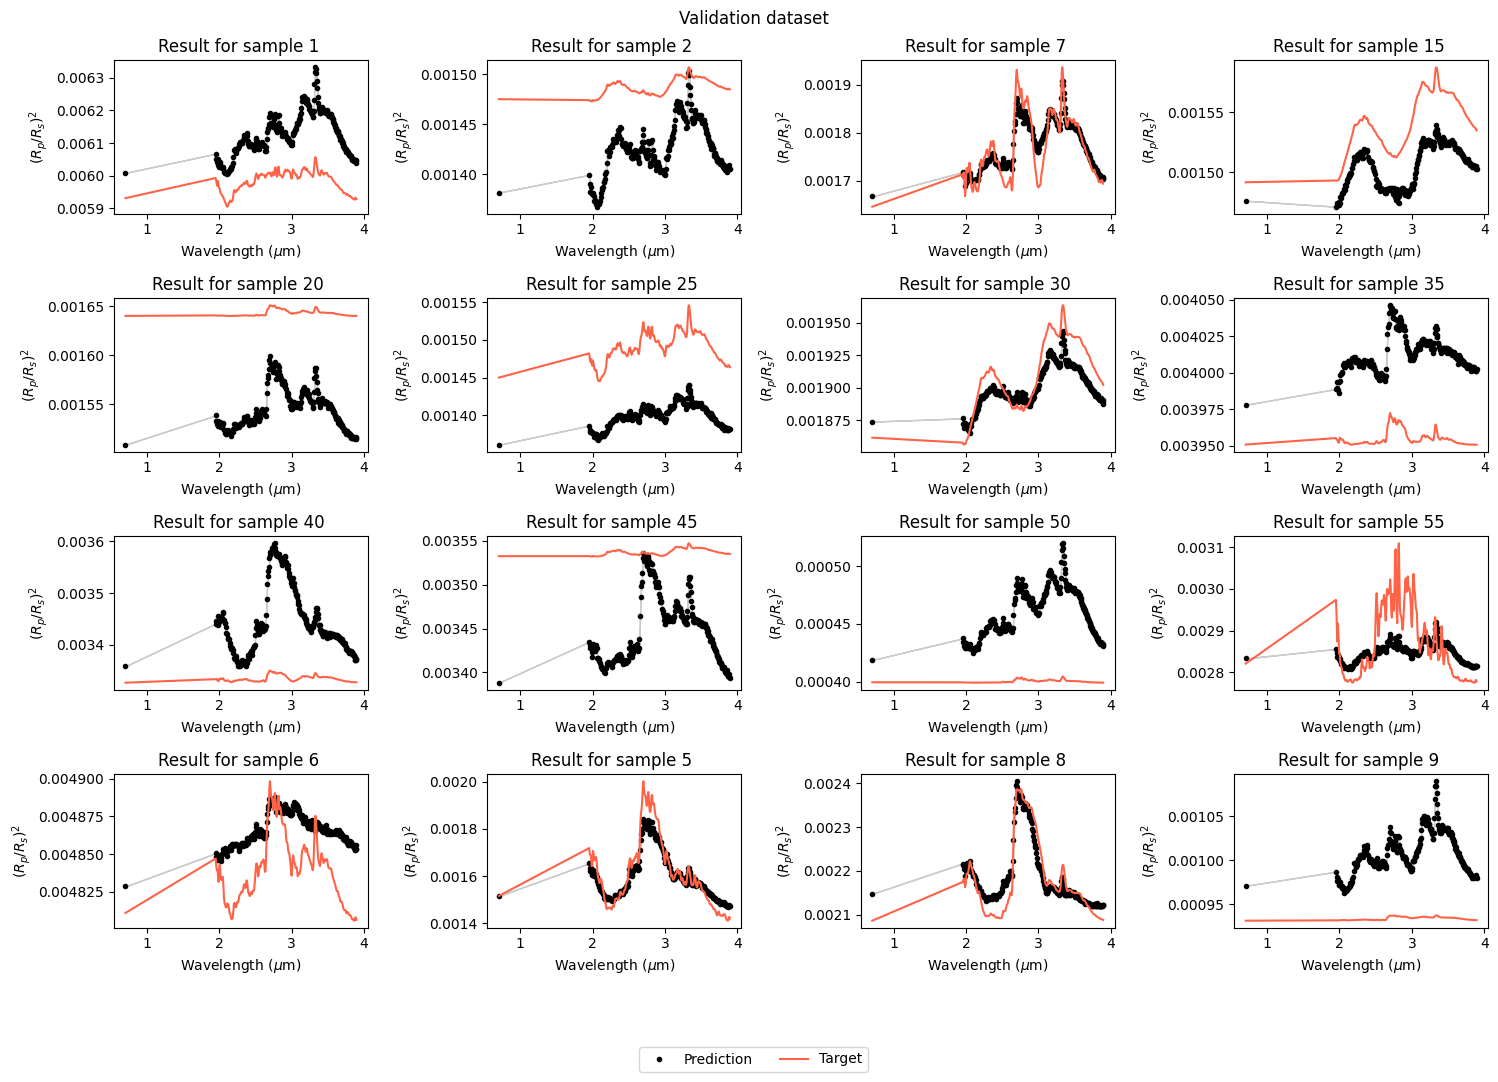

In [101]:
uncertainty_lstm_model = predictions_std_valid_lstm_model

wavelength = np.loadtxt('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter = ',')

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength, predictions_valid_lstm_model[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength, valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength, predictions_valid_lstm_model[p, :] - uncertainty_lstm_model[p], predictions_valid_lstm_model[p, :] + uncertainty_lstm_model[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Validation dataset')
plt.tight_layout()
plt.show()

#### Erro quadrático médio do modelo LSTM

In [102]:
######## PLOTS THE RESULT ########
predictions_lstm_model = predictions_valid_lstm_model
targets_plot = valid_targets
std_lstm_model = predictions_std_valid_lstm_model

predictions_concatenated_plot = np.concatenate(predictions_lstm_model, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)

spectre_valid_std_concatenated = np.concatenate(std_lstm_model, axis=0)
residuals_lstm_model = targets_concatenated_plot - predictions_concatenated_plot
uncertainty_lstm_model = spectre_valid_std_concatenated

MSE_lstm_model = np.sqrt((residuals_lstm_model**2).mean())*1e6

print('MSE (hybrid model): ', format(MSE_lstm_model, '.4f'), 'ppm')

MSE (hybrid model):  105.0880 ppm


#### Média das incertezas do modelo LSTM 

In [118]:
mean_uncertainty_lstm = np.mean(std_lstm_model)
print(f"Mean Uncertainty (LSTM model): {mean_uncertainty_lstm:.4e}")

Mean Uncertainty (LSTM model): 3.1250e-13


#### Plot das predições X targets concatenados do modelo LSTM

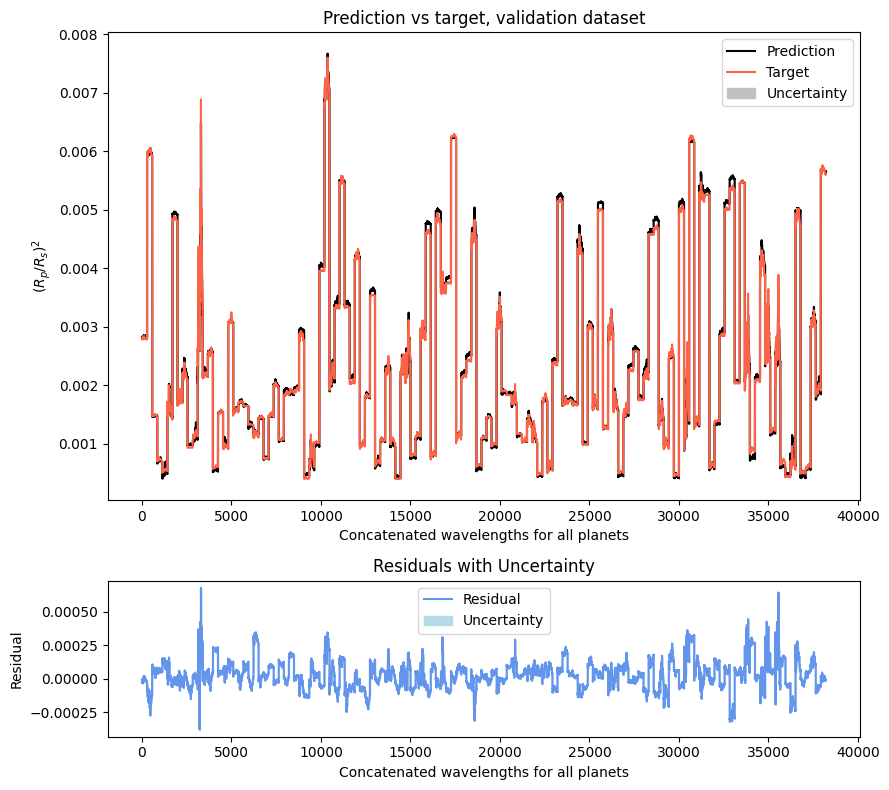

In [158]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)), 
                    predictions_concatenated_plot - uncertainty_lstm_model, 
                    predictions_concatenated_plot + uncertainty_lstm_model, 
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals_lstm_model, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)), 
                    residuals_lstm_model - uncertainty_lstm_model, 
                    residuals_lstm_model + uncertainty_lstm_model, 
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()

## Modelo CNN-LSTM

#### Combinando as predições 1D/2D CNN-LSTM

In [150]:
# Adicionando as flutuações as médias
def add_the_mean (shift, mean) : 
    return shift + mean[:,np.newaxis]

predictions_valid_hybrid_model = add_the_mean(spectre_valid_shift_2dcnn_lstm, spectre_valid_wc_1dcnn_lstm)

predictions_std_valid_hybrid_model = np.sqrt(spectre_valid_std_wc_1dcnn_lstm[:,np.newaxis]**2 + spectre_valid_shift_std_2dcnn_lstm**2)

#### Plot dos espectros do modelo CNN-LSTM

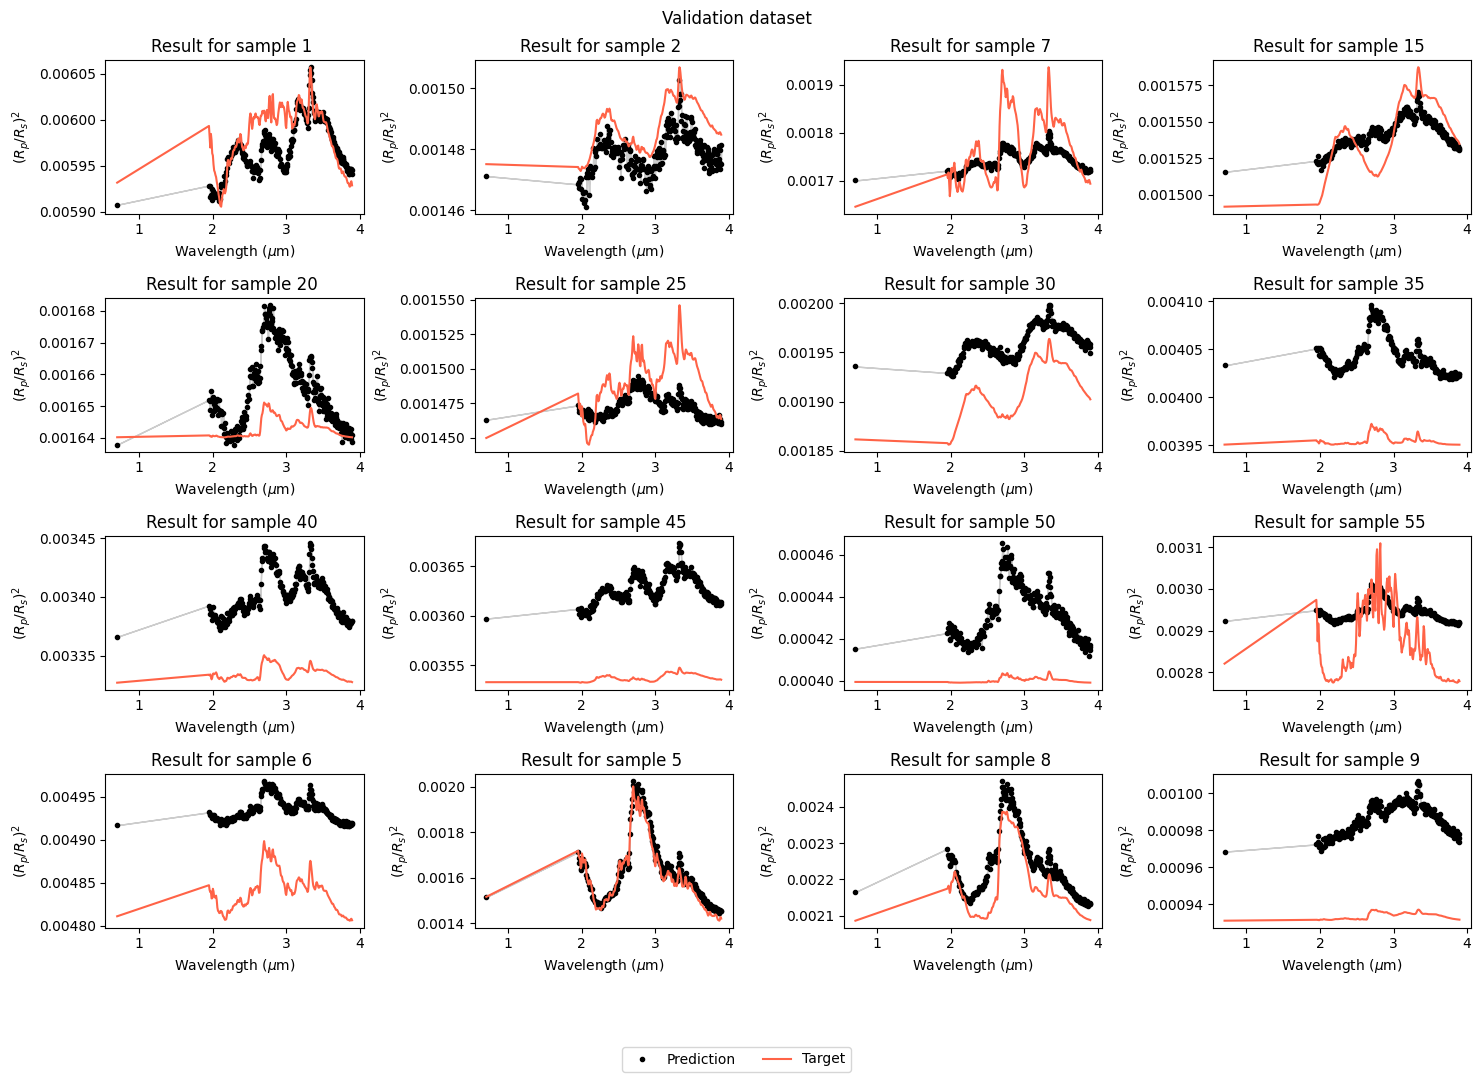

In [151]:
uncertainty_hybrid_model = predictions_std_valid_hybrid_model

wavelength = np.loadtxt('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter = ',')

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength, predictions_valid_hybrid_model[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength, valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength, predictions_valid_hybrid_model[p, :] - uncertainty_hybrid_model[p], predictions_valid_hybrid_model[p, :] + uncertainty_hybrid_model[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Validation dataset')
plt.tight_layout()
plt.show()

#### Erro médio quadrático do modelo CNN-LSTM

In [152]:
######## PLOTS THE RESULT ########
predictions_hybrid_model = predictions_valid_hybrid_model
targets_plot = valid_targets
std_hybrid_model = predictions_std_valid_hybrid_model

predictions_concatenated_plot = np.concatenate(predictions_hybrid_model, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)

spectre_valid_std_concatenated = np.concatenate(std_hybrid_model, axis=0)
residuals_hybrid_model = targets_concatenated_plot - predictions_concatenated_plot
uncertainty_hybrid_model = spectre_valid_std_concatenated

MSE_hybrid_model = np.sqrt((residuals_hybrid_model**2).mean())*1e6

print('MSE (hybrid model): ', format(MSE_hybrid_model, '.4f'), 'ppm')

MSE (hybrid model):  73.1256 ppm


#### Média das incertezas do modelo CNN-LSTM

In [153]:
mean_uncertainty_hybrid = np.mean(std_hybrid_model)
print(f"Mean Uncertainty (Hybrid model): {mean_uncertainty_hybrid:.4e}")

Mean Uncertainty (Hybrid model): 3.0073e-13


#### Plot das predições X targets concatenados do modelo CNN-LSTM

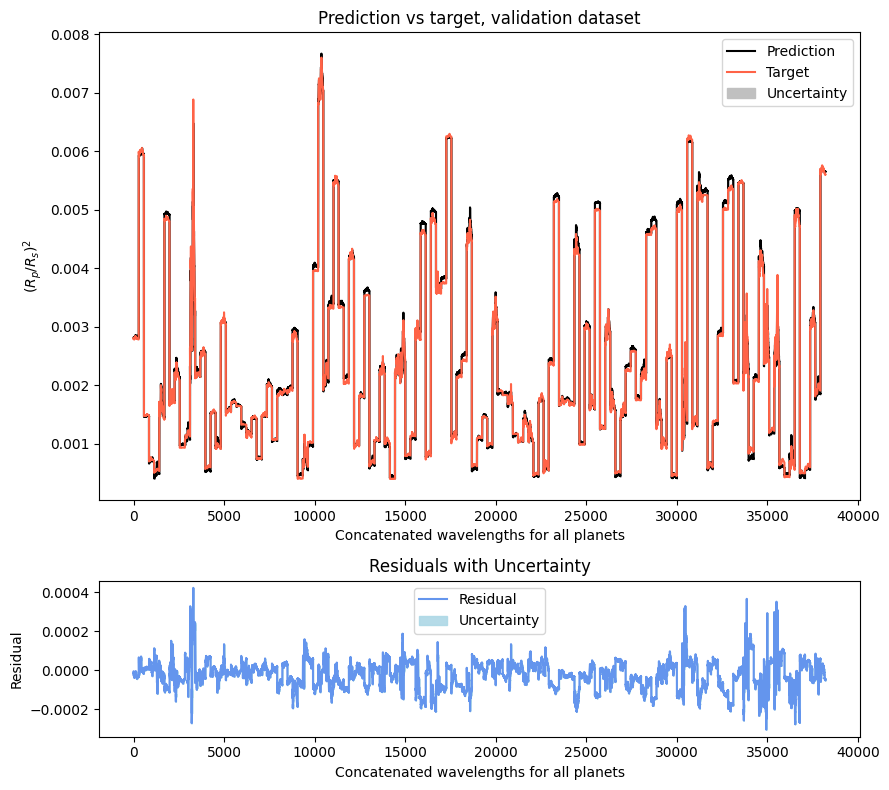

In [155]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)), 
                    predictions_concatenated_plot - uncertainty_hybrid_model, 
                    predictions_concatenated_plot + uncertainty_hybrid_model, 
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals_hybrid_model, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)), 
                    residuals_hybrid_model - uncertainty_hybrid_model, 
                    residuals_hybrid_model + uncertainty_hybrid_model, 
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Avaliação das incertezas do modelo CNN-LSTM

## Modelo CNN

#### Combinando as predições 1D/2D CNN

In [47]:
def add_the_mean (shift, mean) : 
    return shift + mean[:,np.newaxis]

predictions_valid_cnn_model = add_the_mean(spectre_valid_shift_2dcnn,spectre_valid_wc_1dcnn)

predictions_std_valid_cnn_model = np.sqrt(spectre_valid_std_wc_1dcnn[:,np.newaxis]**2 + spectre_valid_shift_std_2dcnn**2)

#### Plot dos espectros do modelo CNN

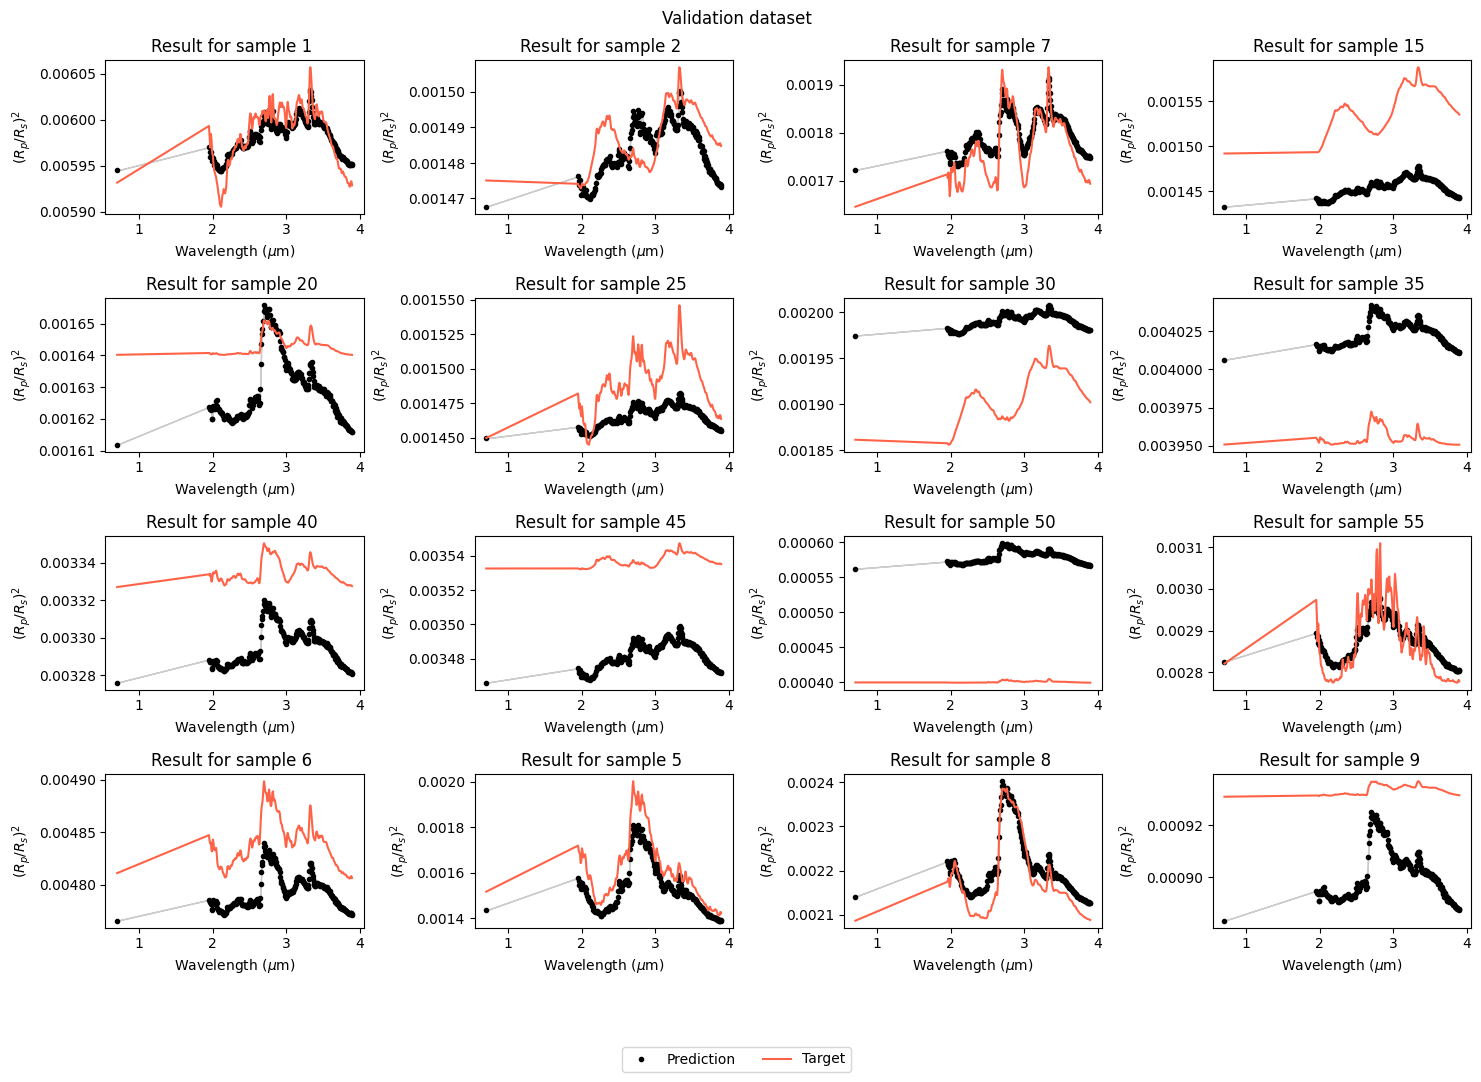

In [48]:
uncertainty_cnn_model = predictions_std_valid_cnn_model

wavelength = np.loadtxt('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter = ',')

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength, predictions_valid_cnn_model[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength, valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength, predictions_valid_cnn_model[p, :] - uncertainty_cnn_model[p], predictions_valid_cnn_model[p, :] + uncertainty_cnn_model[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Validation dataset')
plt.tight_layout()
plt.show()

#### Erro médio quadrático do modelo CNN

In [49]:
######## PLOTS THE RESULT ########
predictions_cnn_model = predictions_valid_cnn_model
targets_plot = valid_targets
std_cnn_model = predictions_std_valid_cnn_model

predictions_concatenated_plot = np.concatenate(predictions_cnn_model, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)
spectre_valid_std_concatenated = np.concatenate(std_cnn_model, axis=0)
residuals_cnn_model = targets_concatenated_plot - predictions_concatenated_plot
uncertainty_cnn_model = spectre_valid_std_concatenated

MSE_cnn_model = np.sqrt((residuals_cnn_model**2).mean())*1e6

print('MSE (CNN model): ', format(MSE_cnn_model, '.4f'), 'ppm')

MSE (CNN model):  95.5454 ppm


#### Média das incertezas do modelo CNN

In [156]:
mean_uncertainty_cnn = np.mean(std_cnn_model)
print(f"Mean Uncertainty (CNN model): {mean_uncertainty_cnn:.4e}")

Mean Uncertainty (CNN model): 2.2548e-13


#### Plot das predições X targets concatenados do modelo CNN

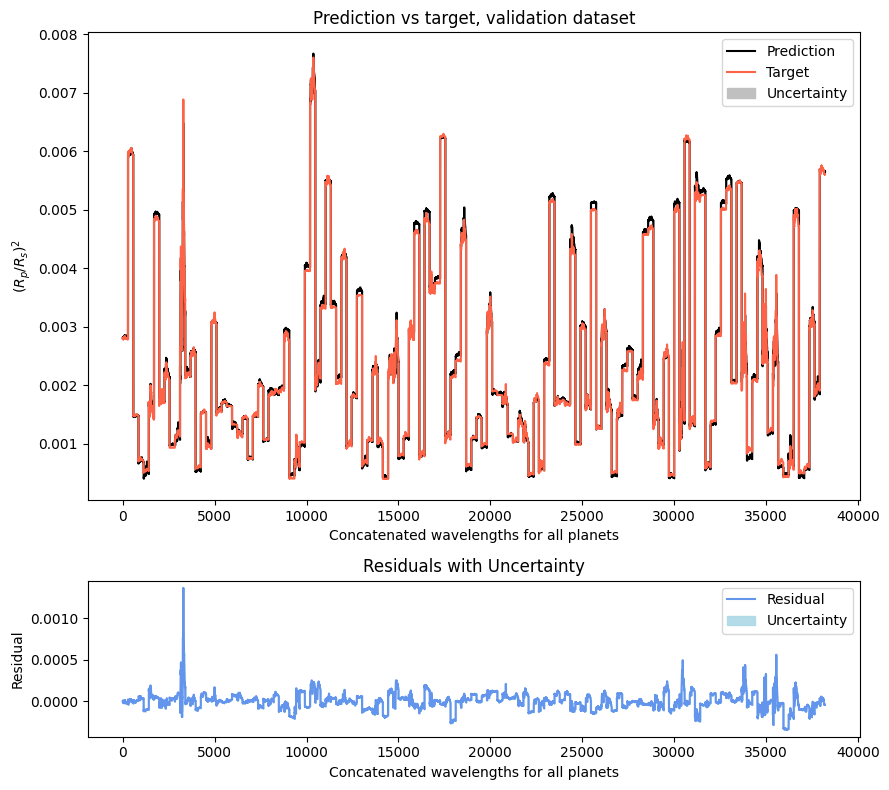

In [157]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)), 
                    predictions_concatenated_plot - uncertainty_cnn_model, 
                    predictions_concatenated_plot + uncertainty_cnn_model, 
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals_cnn_model, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)), 
                    residuals_cnn_model - uncertainty_cnn_model, 
                    residuals_cnn_model + uncertainty_cnn_model, 
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()